# NLP 2024
# Lab 3: Attention and Pre-trained Models

Our practical journey in NLP has so far covered the following:
- Lab 1: Train a bag-of-words model (with variations): In that case, we learned word meanings from the data itself.
- Lab 2: Train an embedding-based model: We still learn from the data itself but hopefully with more effective ways to capture semantics and context.
- Lab 2: Use pre-trained embeddings: We still learn from the data, and pre-training helps generalize.

Now, it's time to not only use a set of pre-trained word vectors (aka representations) but to also use a pre-trained model (like BERT). The model is pre-trained on vast amounts of data and that allows for better generalization. At the same, as we discussed in class, BERT models are based on transformers, which use attention to model sequences (in our case sequences of words). BERT provides for contextualized embeddings, aka the embeddding vector of a word is only determined once the actual context of that word is known: Practically, this allows for words to have different embedding vectors depending on their actual context (e.g. think of the word "bank" and it's multiple meanings in different contexts).

In this lab, we will learn how to load and use pre-trained models (e.g. BERT) from Huggingface. We will be using the same dataset/task as the previous lab, also for comparison reasons.

By the end of this lab you should be able to:

- Load and/or use pre-trained models and tokenizers to solve different NLP tasks
- Inspect and analyze the innter workings (hidden layers etc.) of attention models (like BERT)
- Use attention models to get sentence representations (aka sentence embeddings)
- Use BERT sentence embeddings to solve more complicated tasks like information retrieval
- Compare performance of differemt models on different NLP tasks and assess their effectiveness
- Load and use the basics of `pytorch` (important framework in NLP)

### Score breakdown

| Exercise            | Points |
|---------------------|--------|
| [Exercise 1](#e1)   | 3      |
| [Exercise 2](#e2)   | 3      |
| [Exercise 3](#e3)   | 10     |
| [Exercise 4](#e4)   | 5      |
| [Exercise 5](#e5)   | 5      |
| [Exercise 6](#e6)   | 3      |
| [Exercise 7](#e7)   | 3      |
| [Exercise 8](#e8)   | 3      |
| [Exercise 9](#e9)   | 5      |
| [Exercise 10](#e10) | 5      |
| [Exercise 11](#e11) | 5      |
| [Exercise 12](#e12) | 10     |
| [Exercise 13](#e12) | 10     |
| Total               | 70     |

This score will be scaled down to 1 and that will be your final lab score.

### Instructions for delivery (Deadline: 31/May late night, wildcards possible)

+ Make sure that you include a proper amount/mix of comments, results and code.
+ In the end, make sure that all cells are executed properly and everything you need to show is in your (execucted) notebook.
+ You are asked to deliver only your executed notebook file, .ipnyb and nothing else. Enjoy!
+ Honor code applies to these tasks. Only individual work should be submitted.
+ While you may talk with others about this lab, we ask that you write your solutions individually. If you do discuss specific tasks with others please include their names below.
+ It is mandatory to list and disclose any website (or other resource) you used (e.g. stackoverflow) as well as any genAI tools (e.g. chatGPT) used.

Collaborators: list collaborators here

**I talked with Jerry about...**

Use of genAI tools (e.g. chatGPT), websites (e.g. stackoverflow): list websites where you found code (or other info) as well as include information on how you used genAI tools (e.g. prompts):

I asked chatGPT about...

## 0. Setup (Huggingface + PyTorch  = ❤️)

You should know the drill by now. As in the last lab, we will be using huggingface datasets library ([https://huggingface.co/datasets](https://huggingface.co/datasets)). You can find the detailed documentation and tutorials here: [https://huggingface.co/docs/datasets/en/index](https://huggingface.co/docs/datasets/en/index)

If you don't have it installed you can run the code below:

In [1]:
! pip install -U datasets~=2.18.0

Next, we will need [PyTorch](https://pytorch.org/) installed. It is a very popular deep learning library that offers modularized versions of many of the sequence models we discussed in class. It's an important tool that you may want to practice further if you want to dive deeper into NLP, since much of the current academic and industrial research uses it.

Some resources to look further are given below.

* [Documentation](https://pytorch.org/docs/stable/index.html) (We will need this soon)

* [Installation Instructions](https://pytorch.org/get-started/locally/)

* [Quickstart Tutorial](https://pytorch.org/tutorials/beginner/basics/quickstart_tutorial.html)

The cell below should install the library:

The last bit we need is the huggingface transformers library (here is the documentation [https://huggingface.co/docs/transformers/en/index](https://huggingface.co/docs/transformers/en/index)). Transformers are one of the most influential architectures in handling sequences (not only in language). As we discussed in lectures, they excel at taking into account context (which is the salt-and-pepper of NLP) with mechansisms such as self-attetion, which allows them to weigh the importance of different words in a sentence. If you want to know more, revisit the course material (slides and textbook).

We already used huggingface datasets in previous labs and huggingface transformers integrates nicely with that. Apart from the ease of use, huggingface is also providing pre-trained models of different kinds. The list can be found [here](https://huggingface.co/models) ([https://huggingface.co/models](https://huggingface.co/models)). The following line should be enough to install huggingface transformers library:

In [2]:
! pip install transformers~=4.30.2

As usual, we start by importing some essential Python libraries that we will be using.

In [1]:
import math

import numpy as np
import matplotlib.pyplot as plt
import datasets
import transformers
import tqdm
import torch

/Users/lpaggen/miniforge3/envs/nlp/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. Load and Preprocess Data

For easiness and comparison purposes, we will ue the same dataset as in the previous lab. That will help us re-visit the approach and see whether contextualized architectures can do better in the same problem/task/dataset.

As a reminder:

*Sentence compression* involves rephrasing sentences to make them shorter while still retaining the original meaning. A reliable compression system would be valuable for mobile devices and could also serve as a component in an extractive summarization system.

The dataset we are going to use can be found on [Huggingface](https://huggingface.co/datasets/embedding-data/sentence-compression). It concerns a set of 180,000 pairs of sentences, aka it is a parallel corpus of sentences and their equivalent compressions. It has been collected by harvesting news articles from the Internet where the headline appears to be similar to the first sentence and that property is used to find an "extractive" compression of the sentence.

For example, for the sentence

`"Regulators Friday shut down a small Florida bank, bringing to 119 the number of US bank failures this year amid mounting loan defaults"`

the compressed equivalent (based on the dataset) is:

`"Regulators shut down small Florida bank"`.


For more information you can read the original paper (from Google) [here](https://aclanthology.org/D13-1155.pdf). If you haven't done so for Lab 2, we strongly recommend going over the paper to gain further insights

### 1.1 Loading the Dataset

The dataset will be loaded as a huggingface datgaset. This may take a few minutes because of the large size of the data.

Make sure to inspect the dataset and make sure it is imported properly.

In [2]:
ds = datasets.load_dataset('embedding-data/sentence-compression')
print(ds)

DatasetDict({
    train: Dataset({
        features: ['set'],
        num_rows: 180000
    })
})


In [3]:
for i in range(10):
    print(ds['train'][i])

{'set': ["The USHL completed an expansion draft on Monday as 10 players who were on the rosters of USHL teams during the 2009-10 season were selected by the League's two newest entries, the Muskegon Lumberjacks and Dubuque Fighting Saints.", 'USHL completes expansion draft']}
{'set': ['Major League Baseball Commissioner Bud Selig will be speaking at St. Norbert College next month.', 'Bud Selig to speak at St. Norbert College']}
{'set': ["It's fresh cherry time in Michigan and the best time to enjoy this delicious and nutritious fruit.", "It's cherry time"]}
{'set': ['An Evesham man is facing charges in Pennsylvania after he allegedly dragged his girlfriend from the side of his pickup truck on the campus of Kutztown University in the early morning hours of Dec. 5, police said.', 'Evesham man faces charges for Pa.']}
{'set': ["NRT LLC, one of the nation's largest residential real estate brokerage companies, announced several executive appointments within its Coldwell Banker Residential B

The dataset comes with a `train` split so we will have to split that into `train`/`test` ourselves with the line below.

In [4]:
split_ds = ds['train'].train_test_split(test_size=0.2)
print(split_ds)

DatasetDict({
    train: Dataset({
        features: ['set'],
        num_rows: 144000
    })
    test: Dataset({
        features: ['set'],
        num_rows: 36000
    })
})


### 1.2 Preprocessing the dataset

In this section we will prepare the dataset. Note that previously, we had very much full control over the vocabulary of the dataset (in terms of pre-processing including tokenization). That is because we wanted to build our own embedding model.

By using a *pre-trained* model (like we are going to do at this lab), we need to adhere to the way this model was trained (including the tokenization). Huggingface provides the models, along with the relevant tokenizers, therefore cleaning is not necessary (as in previous labs). You can still include it if you think this would improve the results of the retrieval in the later parts of the lab.

<a name='e1'></a>
### Exercise 1 (3 points)
Instead of cleaning, we will unpack the `set` (containing tuples of full and compressed sentences) column into separate `sentence` and `compressed` columns. This will make it a bit easier for us later.

One key difference in this function is the fact that it will accept a batch of examples (instead of a single example in the exercises in the previous lab). You can iterate through the examples this way:

```
for set in examples['set']
```

The new columns should be lists containing strings (full or compressed sentences) extracted from the `set` column.

Fill in the function below to complete this task

In [5]:
def unpack(examples):
    """
    Unpacks the column `set` into two columns `sentence` and `compressed`.
    Args:
        examples: a batch of examples from the dataset

    Returns: modified examples with two new columns: `sentence` and `compressed`

    """
    sentences = []
    compressed_sentences = []

    ### YOUR CODE HERE

    for set in examples['set']:
        sentences.append(set[0])
        compressed_sentences.append(set[1])

    ### YOUR CODE ENDS HERE

    examples['sentence'] = sentences
    examples['compressed'] = compressed_sentences
    return examples

In the next cell, we will apply the `unpack` function to the whole dataset. Notice that we also drop the original `set` column.

In [6]:
split_ds = split_ds.map(unpack, batched=True, remove_columns=['set'])
print(split_ds)

Map: 100%|██████████| 36000/36000 [00:00<00:00, 244811.28 examples/s]

DatasetDict({
    train: Dataset({
        features: ['sentence', 'compressed'],
        num_rows: 144000
    })
    test: Dataset({
        features: ['sentence', 'compressed'],
        num_rows: 36000
    })
})


Let's examine some examples from the dataset and make sure that we got the results we wanted.

In [7]:
for i in range(10):
    print(split_ds['train'][i])

{'sentence': 'Stocks are gaining in early trading today following the release of GDP data for the third quarter of 2011 and initial jobless claims data for the week ended December 17.', 'compressed': 'Stocks gain in early trading'}
{'sentence': "A referee has died after collapsing during Friday night's High Point Central football game.", 'compressed': 'Referee dies after collapsing during football game'}
{'sentence': 'A MAN was shot multiple times as he was walking in the Big Pond area on Thursday night.', 'compressed': 'Man shot multiple times'}
{'sentence': 'Researchers at the University of Cambridge carried out tests on human subjects which showed that the brain permanently learns a new word after hearing it 160 times in 15 minutes.', 'compressed': 'Brain permanently learns new words in 15 minutes'}
{'sentence': 'After the overwhelming success of the first EMAAR-MGF Indian Masters, the European Tour is now set for India with a tournament exclusively for seniors.', 'compressed': 'Eur

In this lab, we will be using only pre-trained models. That means that we won't be training any new model. This is the reason we can select only the `test` subset for the rest of the notebook (this is where we will be assessing the performance of the pre-trained models). At the same time, we will save much time, as we will not be processing the `train` subset.

In [8]:
test_ds = split_ds['test']
print(test_ds)

Dataset({
    features: ['sentence', 'compressed'],
    num_rows: 36000
})


### 1.3 Loading the Tokenizer

For the first part of this lab, we will be using a pre-trained BERT model from Huggingface, namely the [BERT Uncased](https://huggingface.co/google-bert/bert-base-uncased). You can read the original paper that introduced this model [here](https://aclanthology.org/N19-1423.pdf). This paper has been once of the most cited papers ever (currently having more than 100,000 citations).

We will specify the model name that can be found on the model's card on huggingface (revisit the first link). Make sure to check what other information Huggingface is offering (e.g. how to use the model, limitations, how to inference, etc.).

In [11]:
model_name = 'google-bert/bert-base-uncased'

The models on huggingface come with their own tokenizers. They are loaded separately from the models. We can use [AutoTokenizer](https://huggingface.co/docs/transformers/v4.40.2/en/model_doc/auto#transformers.AutoTokenizer)'s `from_pretrained()` method to load it.

Inspect the output: The loaded object is of `BertTokenizerFast` class. Check the documentation [here](https://huggingface.co/docs/transformers/model_doc/bert#transformers.BertTokenizerFast).

* What is the vocabulary size?

* What are the special tokens and their functions?

Check the original paper to know more and discuss also with your TAs.

In [12]:
tokenizer = transformers.AutoTokenizer.from_pretrained(model_name)
print(tokenizer)

/Users/lpaggen/miniforge3/envs/nlp/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


BertTokenizerFast(name_or_path='google-bert/bert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True)


Next, let's see how we can use it to tokenize some text.

In [13]:
print(test_ds[0]['sentence'])
tokenized = tokenizer(test_ds[0]['sentence'], padding=True, return_tensors='pt')
print("---")
print(type(tokenized))
print("---")
print(tokenized)

Malaysia may close three more popular dive sites in the South China Sea that have been hit by coral bleaching blamed on global warming, an official said on Wednesday.
---
<class 'transformers.tokenization_utils_base.BatchEncoding'>
---
{'input_ids': tensor([[  101,  6027,  2089,  2485,  2093,  2062,  2759, 11529,  4573,  1999,
          1996,  2148,  2859,  2712,  2008,  2031,  2042,  2718,  2011, 11034,
          1038, 19738,  8450, 11248,  2006,  3795, 12959,  1010,  2019,  2880,
          2056,  2006,  9317,  1012,   102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}


Examine the outputs: The tokenizer returned three things:
- `input_ids` - this is a PyTorch tensor ([https://pytorch.org/docs/stable/tensors.html](https://pytorch.org/docs/stable/tensors.html)) with the indices of our tokens. PyTorch tensors are similar to numpy arrays. They hold data in a multidimensional array or matrix. The difference is that PyTorch tensors can be placed and modified on the GPU which greatly improves the speed of execution.
- `token_type_ids` - this tensor holds the information about the index of the sentence. This has to do with the classification objective from the original paper, where two sentences were given and the model had to predict if they are connected. Because we only included a single sentence, we have only zeros here. We will not be concerned with it in this lab.
- `attention_mask` - holds the mask that the model will use to determine if the tokens in the `input_ids` are the real tokens or *padding*. Padding is a technique used to ensure that all input sequences have the same length. BERT (like many other NLP models) process data in batches and requires each sequence in a batch to have the same length, so sequences that are shorter than the maximum sequence length in the batch are padded with special tokens. In this case, because we only inputted a single sentence, the mask contains only ones. Later you will see examples where this is not the case.

Let's see how exactly the sentence was tokenized and how we can retrieve the original text. Notice that some words have been split into multiple tokens (remember when we discussed sub-word tokenization in class?). Also pay attention to the added special tokens, namely `CLS` and `SEP`:

The `[CLS]` token is a special classification token added at the beginning of every input sequence. It stands for "classification" (daah!) and is used by BERT to aggregate information from the entire sequence. The final hidden state corresponding to this token (after passing through the transformer layers) is used as the aggregate sequence representation for classification tasks. We will use this later in the lab!

The `[SEP]` token is used to separate different segments or sentences within the input sequence. It stands for "separator" (daaah again!).

In [14]:
print(tokenized['input_ids'].shape)
print("---")
print(tokenizer.convert_ids_to_tokens(tokenized['input_ids'][0]))
print("---")
print(len(tokenizer.convert_ids_to_tokens(tokenized['input_ids'][0])))
print("---")
print(tokenizer.decode(tokenized['input_ids'][0]))
print("---")
print(tokenizer.decode(tokenized['input_ids'][0], skip_special_tokens=True))

torch.Size([1, 35])
---
['[CLS]', 'malaysia', 'may', 'close', 'three', 'more', 'popular', 'dive', 'sites', 'in', 'the', 'south', 'china', 'sea', 'that', 'have', 'been', 'hit', 'by', 'coral', 'b', '##lea', '##ching', 'blamed', 'on', 'global', 'warming', ',', 'an', 'official', 'said', 'on', 'wednesday', '.', '[SEP]']
---
35
---
[CLS] malaysia may close three more popular dive sites in the south china sea that have been hit by coral bleaching blamed on global warming, an official said on wednesday. [SEP]
---
malaysia may close three more popular dive sites in the south china sea that have been hit by coral bleaching blamed on global warming, an official said on wednesday.


Tokenizer can process a list of sentences. This will create a batched output with tensor's first dimension corresponding to the batch size (the number of sentences we passed to the tokenizer). Examine the following cell and make sure it makes sense to you.

In [15]:
print(test_ds[0:3]['sentence'])
tokenized = tokenizer(test_ds[0:3]['sentence'], padding=True, return_tensors='pt')
print(tokenized)
print(tokenized['input_ids'].shape)
print(tokenizer.convert_ids_to_tokens(tokenized['input_ids'][0]))
print(len(tokenizer.convert_ids_to_tokens(tokenized['input_ids'][0])))
print(tokenizer.decode(tokenized['input_ids'][0]))
print(tokenizer.decode(tokenized['input_ids'][0], skip_special_tokens=True))

['Malaysia may close three more popular dive sites in the South China Sea that have been hit by coral bleaching blamed on global warming, an official said on Wednesday.', "An 18-year-old Ballston Spa man has been indicted on manslaughter and other criminal charges in connection with the death last month of a high school girl who was a passenger in his pickup truck when he crashed it, according to the Saratoga County District Attorney's Office.", 'Iran is struggling to find new buyers for crude oil as Western sanctions start to bite, the Financial Times reported on Monday.']
{'input_ids': tensor([[  101,  6027,  2089,  2485,  2093,  2062,  2759, 11529,  4573,  1999,
          1996,  2148,  2859,  2712,  2008,  2031,  2042,  2718,  2011, 11034,
          1038, 19738,  8450, 11248,  2006,  3795, 12959,  1010,  2019,  2880,
          2056,  2006,  9317,  1012,   102,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
          

### 1.4 Loading the Model

In this section, we will load and examine the model. We will start with selecting the device we will place the model on. This will be a GPU (if one is available) or a CPU.

Google Colab offers free access to GPU, provided there is availability (also baed on quotas which may vary based on your usage and the overall demand on Colab's resources). If you are working locally, then if you don't have a GPU, CPU will be selected. For the first parts of the assignment running on CPU might be okay but when we have to load the dataset a GPU will be necessary.

The following cell will select the device for us.

In [16]:
torch.backends.mps.is_available() # True
device = torch.device("mps")

Now, let's load the model from huggingface and place it (slowly because it's heavy due to the large number of parameters) on the device from the previous cell (the methods `to()`).

In [17]:
model = transformers.AutoModel.from_pretrained(model_name)
model.to(device)
print(model)

Some weights of the model checkpoint at google-bert/bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
  

<a name='e2'></a>
### Exercise 2 (3 points)

Examine the output of the previous cell. Answer the following questions:
- What is the number of transformer layers in this model?
- What is the dimension of the embeddings?
- What is the hidden size of the FFN in the transformer layer?
- What is the total number of parameters of the model (hint: check the `num_parameters()` method of the model)?

In [18]:
model.num_parameters()

109482240

# answers

- What is the number of transformer layers in this model?
-> 12

- What is the dimension of the embeddings?
-> 768

- What is the hidden size of the FFN in the transformer layer?
-> 3072

- What is the total number of parameters of the model (hint: check the `num_parameters()` method of the model)?
-> 109482240

Next, let's use BERT model for inference. We will tokenize the first sentence of our dataset and pass it to the model. We set `output_hidden_states` to `True` in order to have access to the hidden states of the model. Those represent the latent representations after embedding and transformer layers.

In [19]:
tokenized = tokenizer(test_ds[0]['sentence'], padding=True, return_tensors='pt').to(device)
print(tokenized)
model_output = model(**tokenized, output_hidden_states=True)

{'input_ids': tensor([[  101,  6027,  2089,  2485,  2093,  2062,  2759, 11529,  4573,  1999,
          1996,  2148,  2859,  2712,  2008,  2031,  2042,  2718,  2011, 11034,
          1038, 19738,  8450, 11248,  2006,  3795, 12959,  1010,  2019,  2880,
          2056,  2006,  9317,  1012,   102]], device='mps:0'), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], device='mps:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], device='mps:0')}


Examine the next cell and make sure everything makes sense to you. Consult the [documentation](https://huggingface.co/docs/transformers/model_doc/bert#transformers.BertModel.forward) in case of doubt.

In [20]:
print(list(model_output.keys()))
print(type(model_output['pooler_output']))
print(model_output['pooler_output'].shape)
print(type(model_output['hidden_states']))
print(len(model_output['hidden_states']))
print(type(model_output['hidden_states'][0]))
print(model_output['hidden_states'][0].shape)

['last_hidden_state', 'pooler_output', 'hidden_states']
<class 'torch.Tensor'>
torch.Size([1, 768])
<class 'tuple'>
13
<class 'torch.Tensor'>
torch.Size([1, 35, 768])


## 2. Exploring BERT hidden states

In this section we will look in more detail into the embeddings (latent representations) of BERT model. As a reminder, BERT embeddings a type of contextual word embeddings generated by the BERT model. They capture the meaning of words in the actual context. Notice the contrast with the static word embeddings we worked with in the previous lab: Then, we only needed a large corpus to compute word embeddings. In the case of BERT, we need to pass the actual sequence through the model to get the equivalent vector. More specifically, we tokenize the sentence (based on the relevant model and tokenizer), add the special tokanes (`CLS` and `SEP`) and pass the sentence in the model.

We will use the following function to plot the cosine similarity between tokens in different sentences. Examine the code and make sure it makes sense to you.

In [21]:
from typing import List
from itertools import combinations


def plot_evolving_similarities(hidden_states: List[torch.Tensor], tokens_ids_of_interest: List[int]):
    """
    Plots the evolving cosine similarity between the hidden representation of tokens in different sentences.
    Hidden states are provided as a list of tensors where each tensor corresponds to the layer of the model.
    Each tensor contains the hidden representations of each token (second dimension) of each sentence (first dimension).
    For each sentence there have to be a token of interest (can be the same).
    Args:
        hidden_states: a list of tensors containing the hidden representations of sentences
        tokens_ids_of_interest: a list of indices of tokens of interest
    """
    assert hidden_states[0].shape[0] == len(tokens_ids_of_interest), \
        'The batch size of hidden_states must be equal to the number of tokens of interest'

    num_layers = len(hidden_states)
    num_sentences = len(tokens_ids_of_interest)
    sentence_combinations = tuple(combinations(range(num_sentences), 2))
    similarities = [[] for _ in range(len(sentence_combinations))]
    for layer in range(num_layers):
        for i, (sent1, sent2) in enumerate(sentence_combinations):
            embedding1 = model_outputs['hidden_states'][layer][sent1, tokens_ids_of_interest[sent1]]
            embedding2 = model_outputs['hidden_states'][layer][sent2, tokens_ids_of_interest[sent2]]
            cosine_similarity = torch.nn.functional.cosine_similarity(embedding1, embedding2, dim=0)
            similarities[i].append(cosine_similarity.detach().cpu().numpy())

    for i, (sent1, sent2) in enumerate(sentence_combinations):
        plt.plot(range(num_layers), similarities[i],
                 label = f'between {sent1 + 1} and {sent2 + 1}')
    plt.xlabel('layer')
    plt.ylabel('cosine similarity')
    plt.legend()
    plt.show()

Here are three sentences with the word "bank". The word form is the same for all, however the meaning is different in the second sentence. Remember polysemy?

We can plot how the cosine similarity between the embeddings (and latent representations) of the word "bank" in each sentence evolves through the different layers of BERT.

The following code follows the procedure we described above.

{'input_ids': tensor([[  101,  2057,  2097,  6487,  1037,  2924,  2279,  2733,   999,   102,
             0,     0,     0],
        [  101,  1996,  2336, 16791,  6386,  2011,  1996,  2924,  1997,  1996,
          2314,  1012,   102],
        [  101,  1045,  2404,  2769,  1999,  1996,  2924,  1012,   102,     0,
             0,     0,     0]], device='mps:0'), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], device='mps:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0]], device='mps:0')}
['[CLS]', 'we', 'will', 'rob', 'a', 'bank', 'next', 'week', '!', '[SEP]', '[PAD]', '[PAD]', '[PAD]']
['[CLS]', 'the', 'children', 'skipped', 'stones', 'by', 'the', 'bank', 'of', 'the', 'river', '.', '[SEP]']
['[CLS]', 'i', 'put', 'money', 'in', 'the', 'bank', '.', '[SEP]'

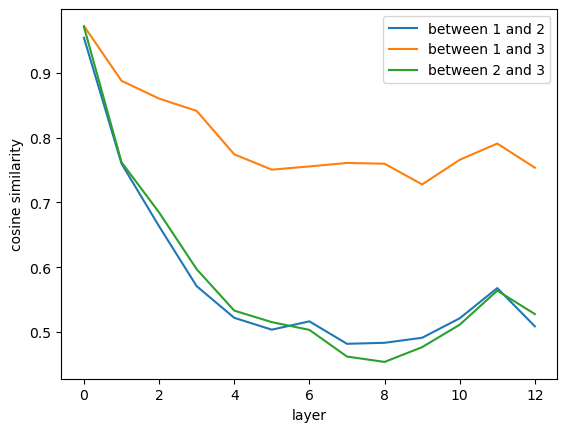

In [22]:
text1 = "We will rob a bank next week!"
text2 = "The children skipped stones by the bank of the river."
text3 = "I put money in the bank."
tokenized = tokenizer([text1, text2, text3], padding=True, return_tensors='pt').to(device)
print(tokenized)

tokens1 = tokenizer.convert_ids_to_tokens(tokenized['input_ids'][0])
tokens2 = tokenizer.convert_ids_to_tokens(tokenized['input_ids'][1])
tokens3 = tokenizer.convert_ids_to_tokens(tokenized['input_ids'][2])
print(tokens1)
print(tokens2)
print(tokens3)

tokens_ids_of_interest = [5, 7, 6]
print(tokens1[tokens_ids_of_interest[0]])
print(tokens2[tokens_ids_of_interest[1]])
print(tokens3[tokens_ids_of_interest[2]])

model_outputs = model(**tokenized, output_hidden_states=True)
plot_evolving_similarities(model_outputs['hidden_states'], tokens_ids_of_interest)

Next, let's plot the evolving similarities of different words: "nice", "bad", and "lovely" in the same context.

{'input_ids': tensor([[ 101, 1996, 4633, 2003, 3835, 2651, 1012,  102],
        [ 101, 1996, 4633, 2003, 2919, 2651, 1012,  102],
        [ 101, 1996, 4633, 2003, 8403, 2651, 1012,  102]], device='mps:0'), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0]], device='mps:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1]], device='mps:0')}
['[CLS]', 'the', 'weather', 'is', 'nice', 'today', '.', '[SEP]']
['[CLS]', 'the', 'weather', 'is', 'bad', 'today', '.', '[SEP]']
['[CLS]', 'the', 'weather', 'is', 'lovely', 'today', '.', '[SEP]']
nice
bad
lovely


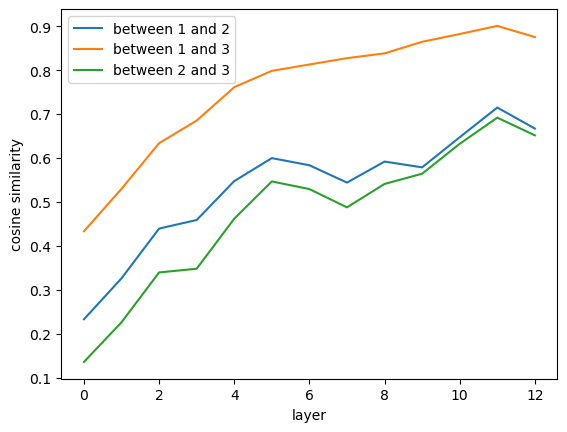

In [23]:
text1 = "The weather is nice today."
text2 = "The weather is bad today."
text3 = "The weather is lovely today."

tokenized = tokenizer([text1, text2, text3], padding=True, return_tensors='pt').to(device)
print(tokenized)

tokens1 = tokenizer.convert_ids_to_tokens(tokenized['input_ids'][0])
tokens2 = tokenizer.convert_ids_to_tokens(tokenized['input_ids'][1])
tokens3 = tokenizer.convert_ids_to_tokens(tokenized['input_ids'][2])
print(tokens1)
print(tokens2)
print(tokens3)

tokens_ids_of_interest = [4, 4, 4]
print(tokens1[tokens_ids_of_interest[0]])
print(tokens2[tokens_ids_of_interest[1]])
print(tokens3[tokens_ids_of_interest[2]])

model_outputs = model(**tokenized, output_hidden_states=True)
plot_evolving_similarities(model_outputs['hidden_states'], tokens_ids_of_interest)

<a name='e3'></a>
### Exercise 3 (10 points)

Take a look at the similarity between the word "bank" in the first example for the first layer (layer index 0)? This corresponds to the embedding layer of BERT. It is close to `1` but not exactly. Why is that?

Try a different set of sentences. Comment on the results of the sentences above and your own. Are the plots showing what you expected to see? Make meaningful comparisons and write your insights below. Feel free to modify the plotting above (if needed), but note that is not necessary.

{'input_ids': tensor([[  101,  1996,  7151,  5520,  2041,  1997,  1996,  5430,  2012, 18406,
          1012,   102,     0],
        [  101,  2002,  2718,  1037,  2188,  2448,  2007,  2010,  2047,  7151,
          1012,   102,     0],
        [  101,  2027,  2109,  1037,  7151, 19034,  2000,  2817,  1996, 23789,
          4176,  1012,   102]], device='mps:0'), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], device='mps:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], device='mps:0')}
['[CLS]', 'the', 'bat', 'flew', 'out', 'of', 'the', 'cave', 'at', 'dusk', '.', '[SEP]', '[PAD]']
['[CLS]', 'he', 'hit', 'a', 'home', 'run', 'with', 'his', 'new', 'bat', '.', '[SEP]', '[PAD]']
['[CLS]', 'they', 'used', 'a', 'bat', 'detector', 'to', 'study', 'the', 'nocturn

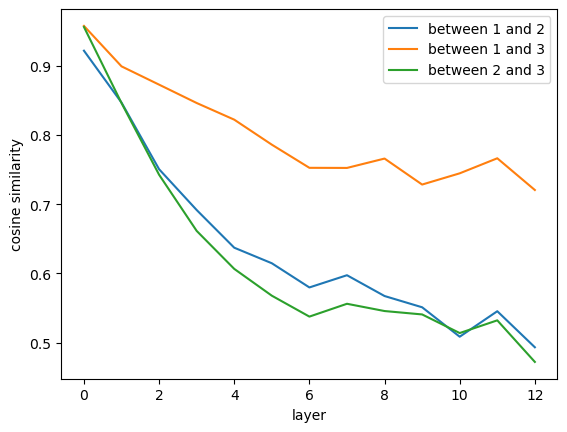

{'input_ids': tensor([[  101,  1996, 11308,  2768, 28266,  1999,  1996,  9409,  1012,   102,
             0,     0,     0,     0,     0,     0],
        [  101,  1996, 11308,  4196,  1996,  3082, 13110,  2000,  1996,  2327,
          1997,  1996,  2311,  1012,   102,     0],
        [  101,  2016,  2018,  2000, 11308,  2014,  3300,  2000,  2156,  1996,
          7700,  2058,  1996,  4306,  1012,   102]], device='mps:0'), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], device='mps:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], device='mps:0')}
['[CLS]', 'the', 'crane', 'stood', 'gracefully', 'in', 'the', 'marsh', '.', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']
['[CLS]', 'the',

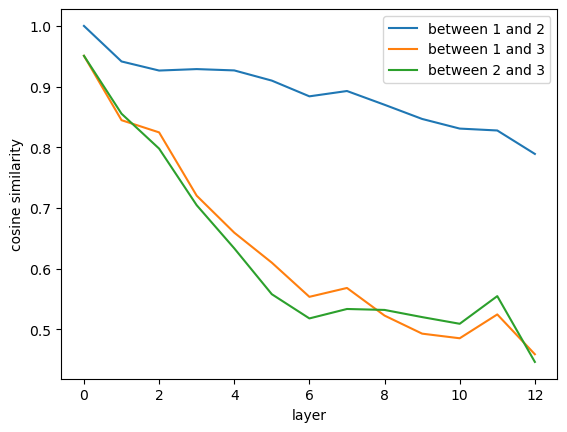

{'input_ids': tensor([[  101,  1996,  7744, 16849, 12128,  2083,  1996, 13580,  5380,   102,
             0,     0,     0,     0],
        [  101,  2002,  4508,  1996,  7744,  3031,  1996, 11255,  2000,  2485,
          2009, 28999,  1012,   102],
        [  101,  2027,  2109,  1037,  2569,  7744,  2000,  2562,  1996, 11661,
          2250, 26143,  1012,   102]], device='mps:0'), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], device='mps:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], device='mps:0')}
['[CLS]', 'the', 'seal', 'swam', 'swiftly', 'through', 'the', 'icy', 'waters', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']
['[CLS]', 'he', 'pressed', 'the', 'seal', 'onto', 'the', 'envelope', 'to', 'close', 'it', 'securely', '.', '[

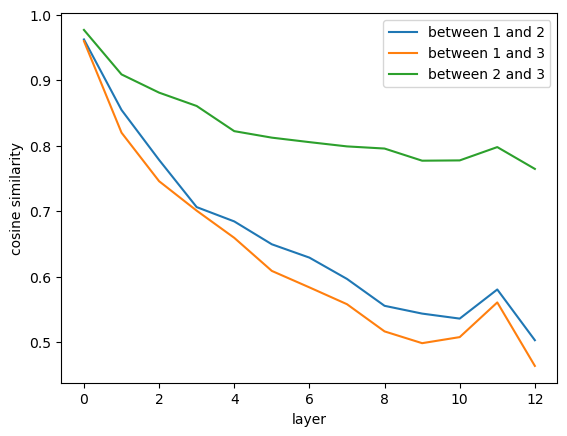

In [24]:
### YOUR CODE HERE

sentences = [["The bat flew out of the cave at dusk.", "He hit a home run with his new bat.", "They used a bat detector to study the nocturnal animals."],
             ["The crane stood gracefully in the marsh.", "The crane lifted the heavy beams to the top of the building.", "She had to crane her neck to see the parade over the crowd."],
             ["The seal swam swiftly through the icy waters", "He pressed the seal onto the envelope to close it securely.", "They used a special seal to keep the container airtight."]]

for i, sentence in enumerate(sentences):
    
    text1 = sentence[0]
    text2 = sentence[1]
    text3 = sentence[2]

    tokenized = tokenizer([text1, text2, text3], padding=True, return_tensors='pt').to(device)
    print(tokenized)

    tokens1 = tokenizer.convert_ids_to_tokens(tokenized['input_ids'][0])
    tokens2 = tokenizer.convert_ids_to_tokens(tokenized['input_ids'][1])
    tokens3 = tokenizer.convert_ids_to_tokens(tokenized['input_ids'][2])
    print(tokens1)
    print(tokens2)
    print(tokens3)

    if i == 0:
        tokens_ids_of_interest = [2, 9, 4]
    elif i == 1:
        tokens_ids_of_interest = [2, 2, 4]
    else:
        tokens_ids_of_interest = [2, 4, 5]
    
    print(tokens1[tokens_ids_of_interest[0]])
    print(tokens2[tokens_ids_of_interest[1]])
    print(tokens3[tokens_ids_of_interest[2]])

    model_outputs = model(**tokenized, output_hidden_states=True)
    plot_evolving_similarities(model_outputs['hidden_states'], tokens_ids_of_interest)

### YOUR CODE ENDS HERE
### NOTICE: you can always add more cells if you need them

# answers

Take a look at the similarity between the word "bank" in the first example for the first layer (layer index 0)? This corresponds to the embedding layer of BERT. It is close to `1` but not exactly. Why is that?
-> the position of the word is different in some sentences, and this is taken into account in this first layer. This is why we observe a similarity below 1 for the same word. 

- I have proposed 3 sets of 3 sentences similar to the exercise above to check the performance of this model:

1 - "The bat flew out of the cave at dusk.", "He hit a home run with his new bat.", "They used a bat detector to study the nocturnal animals."
2 - "The crane stood gracefully in the marsh.", "The crane lifted the heavy beams to the top of the building.", "She had to crane her neck to see the parade over the crowd."
3 - "The seal swam swiftly through the icy waters", "He pressed the seal onto the envelope to close it securely.", "They used a special seal to keep the container airtight."

case 1 -> "bat" should be more similar in sentences 1 and 3 than in 2 and 3, 3 and 1. The plot suggests the model might not have found this pattern quite yet, as the plot of cosine similarity for these words in these sentences show that "bat" is much more similar in sentences 1 and 2, however, sentence 1 uses "bat" as an animal, like 3, and 2 uses "bat" as a baseball bat. 

case 2 -> "crane" should be similar in sentences 1 and 3, but we should not expect too much similarity at all. The plot suggests the following: "crane" is most similar in sentences 1 and 2, which means the model considers here that "crane" in 1 (animal) is similar to "crane" in 2 (construction machine)

case 3 -> "seal" should be similar only between sentences 2 and 3. The plot suggests that the model correctly identified this, finally. 

## 3. Calculating BERT sentence embeddings

It is finally time to use BERT's hidden states as word embeddings. First, you will write a function to aggregate the BERT's hidden representations of the words in a sentence.

<a name='e4'></a>
### Exercise 4 (5 points)


Implement the following function. It will receive the batched input to the model and its output. Calculate the mean embedding of the tokens in each sentence. In particular, get `attention_mask` from the `input_batch` and `hidden_states` from `model_output` (already done for you), and calculate the mean of the hidden states. Remember that you are working with a batch, so both `attention_mask` and `hidden_states` contain multiple sentences (the first dimension of both tensors correspond to the size of the batch). In the end, you should have a tensor with a shape batch_size x embedding_size.

Pay attention to the padded tokens (indicated by the attention mask from the input).

Additionally, the function will receive the `layer` parameter. It will indicate the index of the layer of which the hidden representations of tokens will be aggregated. The default value of `-1` indicates the last layer. The code already selects the hidden states of the specified layer.

Optionally, you can ignore the special tokens `[CLS]` and `[SEP]`.

# chatGPT usage

I cannot (I probably am not the only one) figure out what exactly we need to do here? I do not have a year of experience with pytorch and therefore asked chatGPT for some guidance. I understand how the mask works, and what it does, but I could not have figured out the part where I need to unsqueeze and transform the mask. 

my original code was: 

masked_embeddings = attention_mask * hidden_states

----------------

This does not work, because those do not have the same size (?)

So, I gave chatGPT the instructions of the question, the start of the function, my code, and asked the following: "give me the formulas for calculating the sentence embeddings of a batch of sentences as a mean of token representations"

chatGPT then gave me the code I submitted for this question, it is all chatGPT code. 

In [25]:
def calculate_sentence_embeddings(input_batch, model_output, layer=-1):
    """
    Calculates the sentence embeddings of a batch of sentences as a mean of token representations.
    The representations are taken from the layer of the index provided as a `layer` parameter.
    Args:
        input_batch: tokenized batch of sentences (as returned by the tokenizer), contains `input_ids`, `token_type_ids`, and `attention_mask` tensors
        model_output: the output of the model given the `input_batch`, contains `last_hidden_state`, `pooler_output`, `hidden_states` tensors
        layer: specifies the layer of the hidden states that are used to calculate sentence embedding

    Returns: tensor of the averaged hidden states (from the specified layer) for each example in the batch

    """

    attention_mask = input_batch['attention_mask']
    hidden_states = model_output['hidden_states'][layer]

    # Apply attention mask to hidden states
    masked_hidden_states = hidden_states * attention_mask.unsqueeze(-1)

    # Sum hidden states along the sequence length
    sum_hidden_states = torch.sum(masked_hidden_states, dim=1)

    # Calculate the count of non-padding tokens for each example
    non_pad_tokens = torch.clamp(torch.sum(attention_mask, dim=1), min=1)

    # Calculate the mean of hidden states for each example
    mean_hidden_states = sum_hidden_states / non_pad_tokens.unsqueeze(-1)

    return mean_hidden_states

The following function will plot the evolution of cosine similarities between sentence embeddings based on representations of different layers of the model.

Notice that it will receive a function that is used to calculate the sentence embeddings (that is the function we implemented above).

In [26]:
def plot_evolving_sentence_similarities(input_batch, model_outputs, sentence_embeddings_fn):
    num_layers = len(model_outputs['hidden_states'])
    num_sentences = len(tokens_ids_of_interest)
    sentence_combinations = tuple(combinations(range(num_sentences), 2))
    similarities = [[] for _ in range(len(sentence_combinations))]

    for layer in range(num_layers):
        sentence_embeddings = sentence_embeddings_fn(input_batch, model_outputs, layer)
        for i, (sent1, sent2) in enumerate(sentence_combinations):
            embedding1 = sentence_embeddings[sent1]
            embedding2 = sentence_embeddings[sent2]
            cosine_similarity = torch.nn.functional.cosine_similarity(embedding1, embedding2, dim=0)
            similarities[i].append(cosine_similarity.detach().cpu().numpy())

    for i, (sent1, sent2) in enumerate(sentence_combinations):
        plt.plot(range(num_layers), similarities[i], label=f'between {sent1 + 1} and {sent2 + 1}')

    plt.xlabel('layer')
    plt.ylabel('cosine similarity')
    plt.legend()
    plt.show()


Let's examine the cosine similarities of the sentences with the word "bank" from earlier.

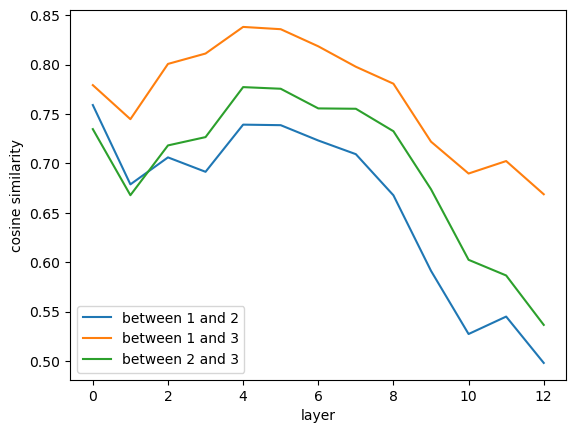

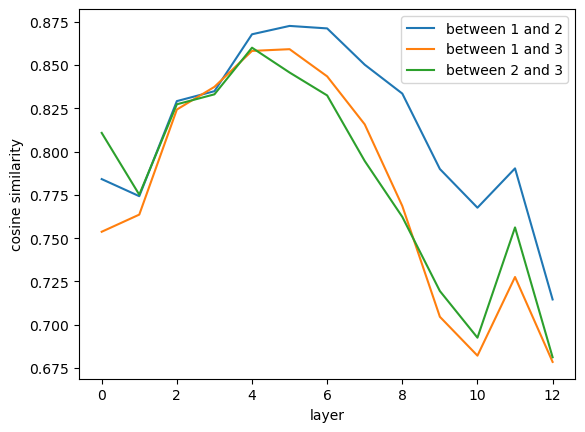

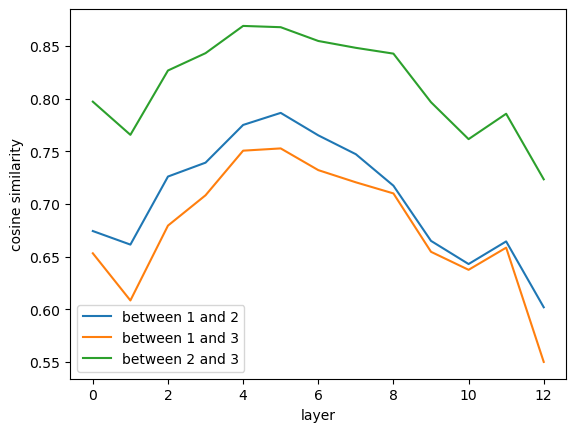

In [27]:
sentences = [["The bat flew out of the cave at dusk.", "He hit a home run with his new bat.", "They used a bat detector to study the nocturnal animals."],
            ["The crane stood gracefully in the marsh.", "The crane lifted the heavy beams to the top of the building.", "She had to crane her neck to see the parade over the crowd."],
             ["The seal swam swiftly through the icy waters", "He pressed the seal onto the envelope to close it securely.", "They used a special seal to keep the container airtight."]]

for text in sentences:
    tokenized = tokenizer([text[0], text[1], text[2]], padding=True, return_tensors='pt').to(device)

    model_outputs = model(**tokenized, output_hidden_states=True)
    plot_evolving_sentence_similarities(tokenized, model_outputs, calculate_sentence_embeddings) # ??? this works but it is not readable at all ??? 

<a name='e5'></a>
### Exercise 5 (5 points)

Try out your sentence embeddings on different sentences. Inspect the results in terms of the different layers. Comment on the results. Are they expected?

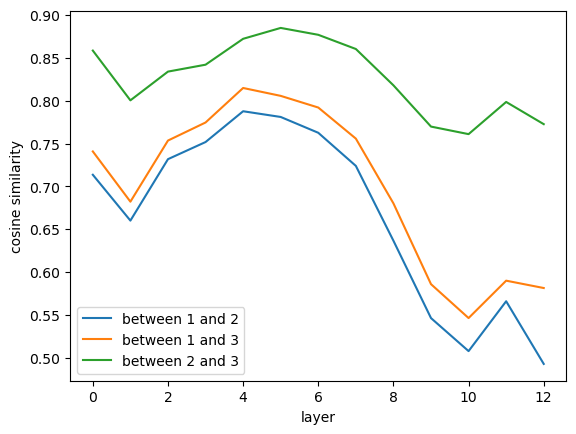

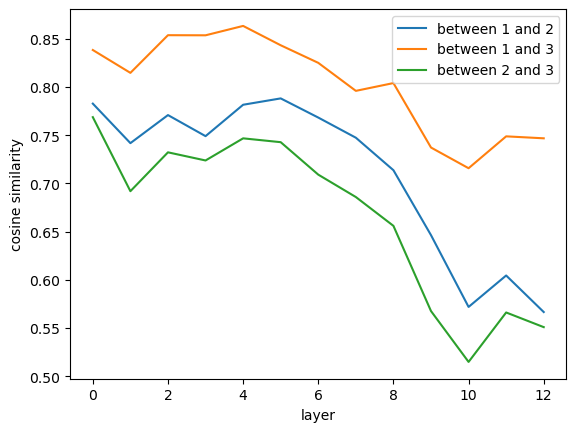

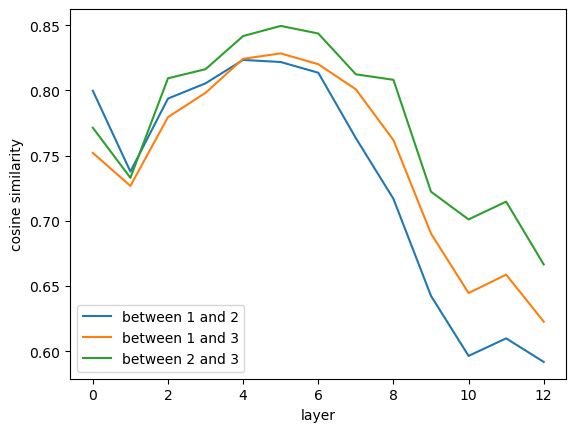

In [28]:
### YOUR CODE HERE

# here i just asked chatGPT: "give me a list of 3 lists of 3 strings each, each string should be a sentence with ambiguous words, to compare cosine similarity" + "make those into the data structure I asked for in python" to get my sentences
ambiguous_sentences = [
    [
        "I need to visit the bank to deposit my paycheck.",
        "The children played by the bank of the river.",
        "He sat on the bank and watched the boats go by."
    ],
    [
        "A bat flew out of the cave at dusk.",
        "She swung the bat and hit a home run.",
        "The bat colony in the cave is fascinating to watch."
    ],
    [
        "The cat chased the mouse across the kitchen.",
        "He clicked the mouse to open the file.",
        "She bought a wireless mouse for her laptop."
    ]
]

for list in ambiguous_sentences:
    
    tokenized = tokenizer([list[0], list[1], list[2]], padding=True, return_tensors='pt').to(device)

    model_outputs = model(**tokenized, output_hidden_states=True)
    plot_evolving_sentence_similarities(tokenized, model_outputs, calculate_sentence_embeddings) # ??? this works but it is not readable at all ??? 

### YOUR CODE ENDS HERE

# answer

The BERT model should work quite well at "understanding" differences between abiguous word senses. We can see this by examining how the model compares a few sentences together.

- For the first set of sentences: 
"I need to visit the bank to deposit my paycheck.",
"The children played by the bank of the river.",
"He sat on the bank and watched the boats go by."

We would expect, as humans, that the model correctly identifies the 2nd and the 3rd sentences are more closely related to each other than they are with the 1st sentence, because "bank" is used in the 2nd and 3rd sentences in a different sense than it is in sentence 1. The model actually correctly identifies this as we want, and what is perhaps even more interesting is that the cosine similarity of 2 and 3 together is consistantly the highest of the 3 pairs, even at early layers. The model passes this test well.

- For the second set of sentences:
"A bat flew out of the cave at dusk.",
"She swung the bat and hit a home run.",
"The bat colony in the cave is fascinating to watch."

Here, we want the model to compute a higher cosine similarity for sentences 1 and 3, rather than for the other sentence pairs. This is because the word "bat" here is used as the animal sense of the word in sentences 1 and 3, and it is used as a baseball bat in sentence 2. Again, we see that the model correctly identifies this, and is able to compute a higher cosine similarity for sentences 1 and 3 than for the other sentence pairs. This is impressive, the model works quite well. 

- For the third set of sentences: 
"The cat chased the mouse across the kitchen.",
"He clicked the mouse to open the file.",
"She bought a wireless mouse for her laptop."

We expect the model to compute a higher similarity for sentences 2 and 3 rather than for the two other pairs of sentences, due to the meaning of the word "mouse" in these sentences. The model correctly does just that, with sentences 2 and 3 being the most similar according to the plots above. One thing to note here, however, is that the model failed to really separate it from the other sentence pairs, all the computed similarities are all too similar. 

### 3.1 Applying BERT sentence embeddings

Next, we will be calculating the word embeddings on our dataset. This is the moment where having GPU will greatly speed up the computations.

As mentioned before, we can use Google Colab [https://colab.google/](https://colab.google/) for this purpose. It gives you access to a GPU for a limited time (after you used this time you will have to wait for some time to use it again). To use a GPU you need to select the runtime type. Go to "Runtime -> Change runtime type". There you can select a CPU or a GPU.

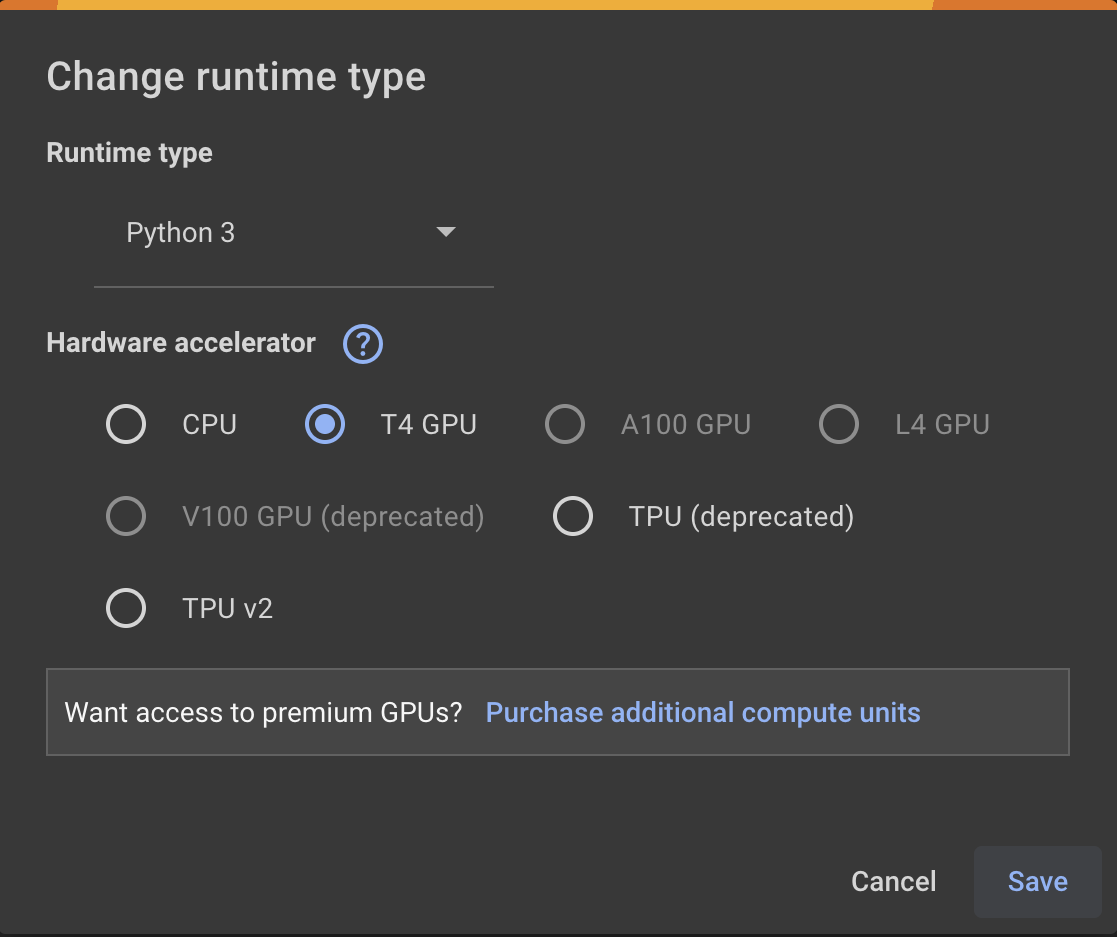

It might be a good idea to first work on a CPU with a slice of the dataset until your code works without problems. Then you can switch to a GPU runtime and work on the whole dataset. Notice that you will have to run all the cells again as the change of the runtime will effectively start a fresh session.

If you have a GPU locally, you don't need to do that, and you can work on the whole dataset from the get go.

To select a portion of the dataset uncomment the following cell. Make sure to comment it again when you are ready to run the notebook on the notebook on the GPU.

In [29]:
device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.has_mps else 'cpu')
model.to(device)

/var/folders/28/nqw3v6ld39g_jrhl3y66nq2w0000gn/T/ipykernel_41083/415270830.py:1: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.has_mps else 'cpu')


BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
  

<a name='e6'></a>
### Exercise 6 (3 points)

We will first tokenize the dataset. Write two functions that will tokenize the two columns - `sentence` and `compressed` - separately. Do not use padding when tokenizing, as we will later use [DataCollator](https://huggingface.co/docs/transformers/en/main_classes/data_collator) to "pack and pad" the examples to form batches.

If you have any doubts please check the following [tutorial](https://huggingface.co/docs/datasets/use_dataset) on Huggingface.

In [30]:
def tokenize_sentence(examples):
    """
    Tokenizes the `sentence` column from the batch of examples and returns the whole output of the tokenizer.
    Args:
        examples: a batch of examples

    Returns: the tokenized `sentence` column (returns the whole output of the tokenizer)

    """
    ### YOUR CODE HERE

    # so, here, if we do not set this truncation and padding to True, the sentence_embedding function is prone to many errors. This is easy to see why, we need to pad when our dimensions # don't match, and our tokens array is not long enough, and we truncate in the opposite case, to make sure all dimensions match, and all computations can actually be performed
    # without us running into errors. 
    # also, setting a max_length for the tokens array is not a bad measure to take, as it further ensures we do not have ANY dimension issues
    tokenized_sentence = tokenizer(examples['sentence'], padding=True, truncation=True, max_length=128, return_tensors='pt') # we also want to return the tensors, like before
    
    ### YOUR CODE ENDS HERE

    return tokenized_sentence


def tokenize_compressed(examples):
    """
    Tokenizes the `compressed` column from the batch of examples and returns the whole output of the tokenizer.
    Args:
        examples: a batch of examples

    Returns: the tokenized `compressed` column (returns the whole output of the tokenizer)

    """

    ### YOUR CODE HERE

    tokenized_compressed = tokenizer(examples['compressed']) # it's a bit more straightforward here, the model doesn't seem to produce any errors for the compressed set.

    ### YOUR CODE ENDS HERE

    return tokenized_compressed

In the next cell, we will apply the functions that you implemented on the dataset (using `map()` method). We will do it twice to obtain two separate datasets for full and compressed sentence each. Notice that we drop the original columns when we form the new datasets.

In [31]:
tokenized_sentence_ds = test_ds.map(tokenize_sentence, batched=True, remove_columns=['sentence', 'compressed'])
print(tokenized_sentence_ds)

tokenized_compressed_ds = test_ds.map(tokenize_compressed, batched=True, remove_columns=['sentence', 'compressed'])
print(tokenized_sentence_ds)

Map:   0%|          | 0/36000 [00:00<?, ? examples/s]

Map: 100%|██████████| 36000/36000 [00:02<00:00, 15643.11 examples/s]


Dataset({
    features: ['input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 36000
})


Map: 100%|██████████| 36000/36000 [00:00<00:00, 84701.33 examples/s]

Dataset({
    features: ['input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 36000
})


Let's examine the first few examples from both datasets. Make sure that they make sense to you.

In [32]:
print(tokenized_sentence_ds[0:3])
print(tokenized_compressed_ds[0:3])

{'input_ids': [[101, 6027, 2089, 2485, 2093, 2062, 2759, 11529, 4573, 1999, 1996, 2148, 2859, 2712, 2008, 2031, 2042, 2718, 2011, 11034, 1038, 19738, 8450, 11248, 2006, 3795, 12959, 1010, 2019, 2880, 2056, 2006, 9317, 1012, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 2019, 2324, 1011, 2095, 1011, 2214, 7395, 2669, 12403, 2158, 2038, 2042, 21801, 2006, 16042, 17298, 13900, 2121, 1998, 2060, 4735, 5571, 1999, 4434, 2007, 1996, 2331, 2197, 3204, 1997, 1037, 2152, 2082, 2611, 2040, 2001, 1037, 4628, 1999, 2010, 15373, 4744, 2043, 2002, 8007, 2009, 1010, 2429, 2000, 1996, 23136, 2221, 2212, 4905, 1005, 1055, 2436, 1012, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In the following cell you can find the function that will apply the provided sentence embedding function to the dataset. It uses the DataCollator we metioned earlier (you are welcome to check the documentation: [https://huggingface.co/docs/transformers/en/main_classes/data_collator](https://huggingface.co/docs/transformers/en/main_classes/data_collator)).

In [33]:
from torch.utils.data.dataloader import DataLoader

def embed_dataset(dataset, model, sentence_embedding_fn, batch_size=8):
    data_collator = transformers.DataCollatorWithPadding(tokenizer)
    data_loader = DataLoader(dataset, batch_size=batch_size, collate_fn=data_collator)
    sentence_embeddings = []
    with torch.no_grad():
        for batch in tqdm.tqdm(data_loader):
            batch.to(device)
            model_output = model(**batch, output_hidden_states=True)
            batch_sentence_embeddings = sentence_embedding_fn(batch, model_output)
            sentence_embeddings.append(batch_sentence_embeddings.detach().cpu())

    sentence_embeddings = torch.concat(sentence_embeddings, dim=0)
    return sentence_embeddings

We will embed the dataset containing sentences by using the function from the previous cell. We will pass your `calculate_sentence_embeddings` function. By default, this function uses the hidden representations of the last layer.

If you are not using a GPU this can take some time depending on your system and your implementation.

To use different layer you can pass different value for the `layer` parameter using python's `functools.partial` function ([https://docs.python.org/3/library/functools.html#functools.partial](https://docs.python.org/3/library/functools.html#functools.partial)).

In [34]:
sentence_embeddings = embed_dataset(tokenized_sentence_ds, model, calculate_sentence_embeddings)
print(sentence_embeddings.shape)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


100%|██████████| 4500/4500 [04:29<00:00, 16.73it/s]


torch.Size([36000, 768])


The following cell will embed the compressed sentences. Make sure to pass the same function for calculating the sentence embeddings.

In [35]:
compressed_embeddings = embed_dataset(tokenized_compressed_ds, model, calculate_sentence_embeddings)
print(compressed_embeddings.shape)

100%|██████████| 4500/4500 [04:30<00:00, 16.66it/s]


torch.Size([36000, 768])


## 4. Retrieving Sentences

Guess what? We are going to try the same task/dataset as the previous lab and hopefully get better performance.

As a reminder, we will be using vector representations (based on the BERT embeddings) to retrieve only the relevant ones based on some user query. It is similar to the a search retrieval task (based on what we discussed in the relevant lecture) where a user provides a query (that is the compressed sentence) and the system returns the sentences that are more similar to the query.

In the information retrieval lecture, we discussed how to solve this retrieval problem by using bag-of-words as a representation basis. In Lab 2, we solved the problem using static word embeddings (learned from our corpus) and by averaring their equivalent vectors per sentence. Now, we are going to use the BERT model (we loaded above) to get contextualized sentence embeddings! Are you as excited as we are? Yes

<a name='e7'></a>
### Exercise 7 (3 points)

First step to a retrieval task is to embed the query (aka find a proper vector representation). We will do it the same way as we did it in the previous exercises. Complete the following function to return the embedding of the provided text.

In [36]:
def embed_query(query, sentence_embedding_fn):
    """
    Embeds the provided query using the model and the `sentence_embedding_fn` function
    Args:
        query: a str with the query
        sentence_embedding_fn: the function used to embed the sentence based on the input and output of the model

    Returns: a PyTorch tensor with the embedded query

    """

    #### YOUR CODE HERE

    # just using tokenizer from before, making sure we pad everything and return tensors - no padding = crash
    # i also had to check https://discuss.pytorch.org/t/torch-embedding-fails-with-runtimeerror-placeholder-storage-has-not-been-allocated-on-mps-device/152124/3
    # to get the "to(device)" thing sorted out, otherwise this produces some RuntimeError

    query_tokenized = tokenizer(query, padding=True, return_tensors='pt').to(device) # so here, it's important to set the device to my GPU, otherwise it won't work
    model_output = model(**query_tokenized, output_hidden_states=True) # i'm using the same code syntax as above, in 3 cells above.
    query_embedding = sentence_embedding_fn(query_tokenized, model_output) # just calling the embedding function, passing the tokens and the output of the model

    ### YOUR CODE ENDS HERE

    return query_embedding.detach().cpu()


Next we will embed the query (which is the same as in the previous lab). What is the dimensionality of the embedding?

In [37]:
query = "volcano erupted"
print(query)

query_embedding = embed_query(query, calculate_sentence_embeddings)
print(query_embedding.shape)
#print(query_embedding)

volcano erupted
torch.Size([1, 768])


<a name='e8'></a>
### Exercise 8 (3 points)

The next step in our retrieval system, would be to calculate the proximity of a query to our retrieval corpus (in our case that is all the sentences).

Complete the following function to calculate the cosine similarity between a vector (first parameter `vector`, that will usually be the query vector) and all other vectors (second parameter `other_vectors`, that will be the sentence embeddings in our case).

The corresponding function from the previous lab would actually work without changes, as PyTorch's tensors are automatically cast into numpy arrays. That said, convert the function into PyTorch to see how the two libraries are similar to each other.

Note that the `other_vectors` parameter is a single PyTorch tensor of size `N x D`, where $N$ is the number of vectors and $D$ is the dimension of each vector.

In [38]:
def cosine_similarity_1_to_n(vector, other_vectors):
    """
    Calculates the cosine similarity between a single vector and other vectors.
    Args:
        vector: a tensor representing a vector of D dimensions
        other_vectors: a 2D tensor representing other vectors (of the size NxD, where N is the number of vectors and D is their dimension)

    Returns: a 1D numpy array of size N containing the cosine similarity between the vector and all the other vectors

    """

    #### YOUR CODE HERE
    
    # my original code is like this:
    # not much changes

    # dot = np.dot(other_vectors, vector)
    # norm_vector = np.linalg.norm(vector)
    # other_norm = np.linalg.norm(other_vectors, axis = 1)
    # cos_sim = dot / (norm_vector * other_norm)

    dot = torch.mm(other_vectors, vector.unsqueeze(1)) # we always need to use "unsqueeze" here, it allows us to use matrix multiplication (pytorch.mm)
    norm_vector = torch.norm(vector) # pytorch here just has a method for normalizing arrays, so i use it
    other_norm = torch.norm(other_vectors, dim=1) # same as above, except need dim=1 for multiple arrays
    cos_sim = dot / (norm_vector * other_norm.unsqueeze(1)) # this is the same as before, use "unsqueeze" for any vector/matrix operations

    return cos_sim.squeeze()



    ### YOUR CODE ENDS HERE

We will use the function to calculate the similarity of all sentences in the dataset to our query.

In [39]:
query_similarity = cosine_similarity_1_to_n(query_embedding[0], sentence_embeddings)
print(query_similarity.shape)
print(query_similarity[:10])

torch.Size([36000])
tensor([0.4769, 0.4164, 0.4670, 0.4439, 0.4333, 0.4505, 0.3730, 0.4716, 0.4586,
        0.3969])


The following cell will select the most similar sentence.

In [40]:
most_similar = int(np.argmax(query_similarity))
print(most_similar)
print(query_similarity[most_similar])
print(test_ds[most_similar]['sentence'])

28268
tensor(0.6622)
Microburst rips up parts of West Yellowstone, Montana.


The following function will return the indices of the top-k elements in the array.

In [41]:
def top_k_indices(array, k, sorted=True):
    """
    Returns top-k indices from the 1D array. If `sorted` is `True` the returned indices are sorted in the descending order
    Args:
        array: a 1D numpy array
        k: a number of top indices to return
        sorted: if True, the returned indices are sorted in descending order

    Returns: a 1D array containing top-k indices

    """
    top_k = np.argpartition(array, -k)[-k:]
    if sorted:
        selected = array[top_k]
        sorted_selected = (-selected).argsort()
        top_k = top_k[sorted_selected]
    return top_k

In [42]:
top_indices = top_k_indices(query_similarity, k=10).tolist()
for idx in top_indices:
    print(split_ds['test'][idx]['sentence'])
    print(f'similarity: {query_similarity[idx]}')

Microburst rips up parts of West Yellowstone, Montana.
similarity: 0.6621603965759277
Wind causes problems during house fire fight near SW 52nd and Monte.
similarity: 0.6076445579528809
A 5,1 magnitude quake hit areas of western Greece.
similarity: 0.5990485548973083
More confirmation that human activity caused ocean warming.
similarity: 0.5972609519958496
President Barack Obama today announced that he has discovered huge oil reserve beneath White House.
similarity: 0.5949946641921997
Bus hits UT student during foam sword fight.
similarity: 0.5894033312797546
A car caught in fire mysteriously in the city on Thursday morning.
similarity: 0.589091956615448
economy added few jobs in January as stormy weather likely kept people out of work.
similarity: 0.5868371725082397
Court date for Patz suspect put off has been postponed.
similarity: 0.586216926574707
A volcano has erupted near Tokyo, spewing a plume of smoke over a mile high and sending ash over parts of the city.
similarity: 0.585860

<a name='e9'></a>
### Exercise 9 (5 points)

Experiment with different queries (taking into account the nature of the dataset and your insights from the analysis so far).

Does the search perform well? When does it fail? Discuss several examples that are we get an expected but also unexpected results (find at least 5 from each category). Try to provide reasons for the good/bad result in each case. Optionally, if you completed the previous lab, try the examples from that case. What do you observe?

In [43]:
#### YOUR CODE HERE

sentences = ["the cat ate all the food",
            "the police shot at the intruders, killing them",
            "The bank is by the river",
            "natural language processing is hard",
            'mathematics is fun',
            "Rob robbed the bank by the river",
            "americans like football",
            "many people dislike celebrities like Elon Musk",
            "I like to drive my car to the supermarket",
            "Taylor Swift likes to take her plane anywhere"]

for qu in sentences:
    query_embedding = embed_query(qu, calculate_sentence_embeddings)

    query_similarity = cosine_similarity_1_to_n(query_embedding[0], sentence_embeddings)

    most_similar = int(np.argmax(query_similarity))
    print(f"OG sentence: {qu}")
    print(test_ds[most_similar]['sentence'])
    print(f'similarity: {query_similarity[idx]}')
    print("\n")

### YOUR CODE ENDS HERE

OG sentence: the cat ate all the food
San Diego Zoo said its newly named baby panda is continuing its good health.
similarity: 0.4804702401161194


OG sentence: the police shot at the intruders, killing them
A suspect has been shot and killed by Milwaukee police officers.
similarity: 0.5610818862915039


OG sentence: The bank is by the river
After being closed for almost six months, the bridge leading to Bassway Wildlife Strip is open again.
similarity: 0.4448583424091339


OG sentence: natural language processing is hard
Robots are developing their own language to help them navigate and improve their intellectual ability.
similarity: 0.4625503718852997


OG sentence: mathematics is fun
reminders that politics can be fun.
similarity: 0.29258862137794495


OG sentence: Rob robbed the bank by the river
Dacoits robbed a house here Thursday and looted cash and golden jewellery.
similarity: 0.4130789041519165


OG sentence: americans like football
Phoenix - Baseball players love their glove

# answers to Q9

## correct classifications
## note that this is subject to change, everytime you run the notebook the sentences will change

- query: the cat ate all the food
- closest: We need dry cat food for our Pet Food Bank!
- score: 0.5620005130767822
- -> the model, this time (as compared to lab2) was able to find a sentence with the word "cat" inside it. Now, it's far from a perfect match, but it is already an improvement on the previous labs, I would say the sentence is somewhat similar to my query. 

- query: natural language processing is hard
- closest: Despite all the Objective-C propaganda it was interesting to note that CoreUI was actually written in C++.
- score: 0.5147289633750916
- -> pretty interesting here, the model somehow matched "natural language processing" with a sentence containing programming words. This to me shows the model takes context of words into account way better than the previous labs. The reason we might not have a perfect match here is simply because I doubt the sentence "natural language processing" appear anywhere in the dataset. 

- query: americans like football
- closest: From mites to NHL, nicknames a hockey tradition The best names in the NHL are the ones that never make the roster.
- score: 0.38338902592658997
-> Here, the closest sentence is also quite interesting. Desite having such a low cosine similarity to the original query, the model still was able to find a sentence which had sports as a subject, hockey at that. I would not consider this an exact match at all, but this model does perform better than the word2vec model we used in the previous lab. The model probably was unable to find a match for "football", but did incorporate it in a way, "NHL" is a US thing, after all. 

- query: many people dislike celebrities like Elon Musk
- closest: Hip-hop star SHWAYZE is to call his unborn baby son HENDRIX after his gui tar god hero.
- score: 0.49796217679977417
-> Again, like above, despite not finding an exact match to "Elon Musk", which was expected, the model is still able to use "celebrity" to find a sentence with another celebrity as its subject. The model actually is able to make the link here between "celebrity" and "star", which is very impressive, when comparing it to word2vec. 

- query: Taylor Swift likes to take her plane anywhere
- closest: Popstar Kelly Clarkson loves buying her own album the moment it hits the market, as she finds it utterly thrilling.
- score: 0.4960997402667999
-> the model was not only able to make the link between "taylor swift" being a celebrity, it was also able to go further and determine that Taylor Swift is in fact a popstar, so it retrieved a sentence with the word popstar in it. this is also impressive, even if the classification is far from perfect.

## incorrect classification

- query: Rob robbed the bank by the river
- closest: A MAN drowned in the River Great Ouse at Kelpie Marine in Roxton after he fell in and became trapped.
- score: 0.5685213804244995
- -> Here, the model fails to understand the meaning of the sentence, and instead chooses to place more weight on "river" rather than on "rob bank". It shows that the model is not perfect, because this is a mistake. 

- query: mathematics is fun
- closest: What happens when jazz meets Kunqu Opera?
- score: 0.40441378951072693
-> Here, it might be a case of "mathematics" never appearing in the dataset? I can find no other reason why the model would be unable to find something close to such a simple sentence otherwise

- query: The bank is by the river
- closest: A naked body of a missing man was found Thursday afternoon in a small pond next to the Saltair.
- score: 0.49494990706443787
-> this one is quite spectacular, but it is expected. The query itself is quite ambiguous, this is probably why the model is unable to "uderstand" the sense of it. What is perhaps a bit surpsing is the whole mention of a murder, I am sure the dataset has sentences with "river" and "bank" in other contexts.

- query: mathematics is fun
- closest: Juliet once said ``What's in a name?
- score: 0.3704950213432312
-> here, the model totally fails to find a good match to the query I provided it with, and produces an output which really has nothing to do with my original query. I would suppose this is a case of really out of vocabulary words, "mathematics" probably isn't in the dataset at all, and the model probably does not know of any good substitutes for that word. 

- query: I like to drive my car to the supermarket
- closest: She said in an interview with Marie Claire magazine: ``I don't really have girlfriends in movies, if you've noticed. Well, I have a few girlfriends, I just... I stay at home a lot. I'm just not very social. I don't do a lot with them, and I'm very homebound.
- score: 0.45203348994255066
-> here, I will argue that maybe the model is able to find a link between leaving home with the car, to "I stay at home a lot" in the retrieved sentence. It might be a stretch, but it would not surprise me if this was the reason why the model determined this sentence was the closest to the original query I gave it. Either this, or there are just not many words like "car" and "supermarket" in the dataset? 

## 5. Evaluating Retrieval

In this section (as with the previous lab) we will try to evaluate how good our sentence retrieval system is. To keep the computational resources manageable, we will use the test set for that as its size is more manageable.

Recall from the lecture in IR that there are several metrics to evaluate retrieval performance by taking into account the relevance of the retrieved results to the query. We will use Recall@K here (for more metrics and more details refer to the lecture slides and the textbooks).

RRecall@K is a metric used to measure the effectiveness of a search system in retrieving relevant documents within the top $K$ retrieved documents. It calculates the proportion of relevant documents retrieved within the top-$K$ results, compared to the total number of relevant documents in the collection.

$
\text{Recall@K} = \frac{\text{Number of relevant documents retrieved in the top }-K}{\text{Total number of relevant documents}}
$

In our case, we have a sentence, and it's compressed version. To test our system, we will treat compressed sentences as the queries. Each query will have only a single relevant sentence - the corresponding uncompressed sentence.

Therefore, for the calculation of Recall@K we will take into account whether the correct retrieved result is contained within the first $K$ retrieved results. For example, if for a query (i.e. a compressed sentence) we retrieve 10 results and within these we see the relevant one (i.e. the full sentence), then Recall@10 = 1.

<a name='e10'></a>
### Exercise 10 (5 points)

In this exercise you will revisit your implementation of the cosine siliarity. Generalize it so that it can accept two PyTorch tensors containing two sets of vectors (first one containing $M$ vectors and the second one $N$ vectors). Compute the cosine similarity between each pair of vectors coming from the two sets. The result should be a tensor of size $M x N$.

Once again, try to write an efficient code. This means no loops. Remember the relation between matrix multiplication and dot product. (Depending on your implementation of the previous function calculating cosine similarity, this one can be almost the same)

In [44]:
def cosine_similarity_m_to_n(vectors, other_vectors):
    """
    Calculates the cosine similarity between a multiple vectors and other vectors.
    Args:
        vectors: a numpy array representing M number of vectors of D dimensions (of the size MxD)
        other_vectors: a 2D numpy array representing other vectors (of the size NxD, where N is the number of vectors and D is their dimension)

    Returns: a numpy array of cosine similarity between all the vectors and all the other vectors

    """

    #### YOUR CODE HERE

    # so, here, it's the same code as in the previous lab, except i'm using pytorch.

    # dot_products = np.dot(vectors, other_vectors.T) # transpose the second array, to obtain a MxN dot product
    # norms2 = np.linalg.norm(vectors, axis=1, keepdims = True) # norm vector 2
    # cosine_similarity_matrix = dot_products / (norms1 * norms2) # compute cos distance same way we did before
    # as in the previous lab, this is inspired by https://stackoverflow.com/questions/74950152/fastest-way-to-calculate-cosine-similartity-between-two-2d-arrays

    # i can just implement the exact same logic, this time using PyTorch operations
    dot = torch.mm(vectors, other_vectors.t())  # we need to transpose the "other_vectors" to make this compatible for mm
    norm_vectors = torch.norm(vectors, dim=1).unsqueeze(1) # we add a second dimension, otherwise it's not going to work
    norm_other_vectors = torch.norm(other_vectors, dim=1).unsqueeze(0)  # same as above
    cos_sim = dot / (norm_vectors * norm_other_vectors)

    return cos_sim
    ### YOUR CODE ENDS HERE

The following function will use your implementation to calculate Recall@K based on the similarity matrix.

In [45]:
def calculate_recall(queries, sentences, k, batch_size=1000):
    """
    Calculates recall@k given the embeddings of the queries and sentences.
    Assumes that only a single sentence with the same index as query is relevant.
    Batching is implemented to avoid high memory usage.
    Args:
        queries: a numpy array with the embeddings of N queries
        sentences: a numpy array with the embeddings of N sentences available for retrieval
        k: number of top results to search for the relevant sentence
        batch_size: number of queries to process at a time

    Returns: calculated recall@k

    """
    n_queries = queries.shape[0]
    if batch_size is None:
        batch_size = n_queries

    n_batches = math.ceil(n_queries / batch_size)
    last_batch_size = n_queries % batch_size if n_queries != batch_size else batch_size

    correct = np.zeros(n_queries).astype(bool)
    with tqdm.tqdm(total=n_queries) as pbar:
        for b in range(n_batches):
            effective_batch_size = last_batch_size if b == (n_batches - 1) else batch_size
            batch_start_index = b * batch_size

            queries_batch = queries[batch_start_index:batch_start_index + effective_batch_size]
            batch_similarity = cosine_similarity_m_to_n(queries_batch, sentences)

            for i in range(effective_batch_size):
                query_index = i + batch_start_index
                query_similarity = batch_similarity[i]
                top_k = top_k_indices(query_similarity, k=k, sorted=False)

                if query_index in top_k:
                    correct[query_index] = True

                pbar.update(1)

    n_correct = np.sum(correct)
    n_total = correct.shape[0]
    recall = n_correct / n_total
    return recall

You can use it like so:

In [46]:
recall_at_1 = calculate_recall(compressed_embeddings, sentence_embeddings, k=1, batch_size=1000)
print(f'\n{recall_at_1 * 100:.2f}%')

 97%|█████████▋| 35000/36000 [00:09<00:00, 3814.06it/s]


45.27%


<a name='e11'></a>
### Exercise 11 (5 points)

Calculate recall for different values of $K$. Comment on how recall changes based on the value of $K$. Are the results expected or surprising? Comment again on different examples (like in Exercise 9) but now take into account the results of recall at different levels of $K$.

At this stage, do not experiment further. That will come in the next Sections which are more open ended.

total relevant documents: 76
relevant documents in top 1: 1
k = 1
1.32%


total relevant documents: 76
relevant documents in top 21: 21
k = 21
27.63%


total relevant documents: 76
relevant documents in top 41: 41
k = 41
53.95%


total relevant documents: 76
relevant documents in top 61: 61
k = 61
80.26%


total relevant documents: 76
relevant documents in top 81: 76
k = 81
100.00%


total relevant documents: 76
relevant documents in top 101: 76
k = 101
100.00%


total relevant documents: 76
relevant documents in top 121: 76
k = 121
100.00%


total relevant documents: 76
relevant documents in top 141: 76
k = 141
100.00%


total relevant documents: 76
relevant documents in top 161: 76
k = 161
100.00%


total relevant documents: 76
relevant documents in top 181: 76
k = 181
100.00%




Text(0, 0.5, 'Recall at K')

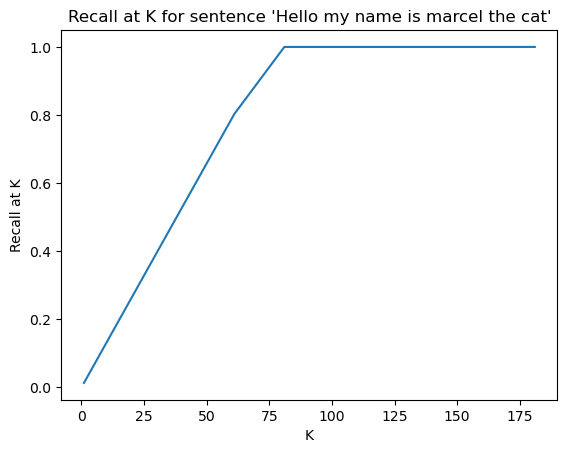

In [47]:
# this is my own code for a single sentence, but it's far from optimal, it just works fine, except you need to set a threshold for what is considered
# similar and what is not, which is far from ideal

query = "hello my name is marcel the cat"

def calculate_recall_single(query, k, relevance_threshold): # would add param for the sent_word2vec but no need here 
    query_embedding = embed_query(query, calculate_sentence_embeddings)
    query_similarity = cosine_similarity_1_to_n(query_embedding[0], sentence_embeddings)
    relevant_cnt = sum(1 for sim in query_similarity if sim >= relevance_threshold) # 0.4 works better than aything else atm, otherwise will not find anything
    top_k = top_k_indices(query_similarity, k=k, sorted=False) # get the top k idx
    k_relevant_cnt = sum(1 for idx in top_k if query_similarity[idx] >= relevance_threshold)
    try:
        print(f"total relevant documents: {relevant_cnt}")
        print(f"relevant documents in top {k}: {k_relevant_cnt}")
        return (k_relevant_cnt / relevant_cnt)
    except ZeroDivisionError:
        print(f"No relevant documents found in top {k}")
        return 0

recall_list = [] # i store recall at K
recall_idx = [] # i store the index, or just K

query = 'the police shot at the intruders and killed them all'

# now this model is the normal model, unchanged word2vec
for i in range(1, 200, 20):
    recall_at_i = calculate_recall_single(query, i, 0.72)
    print(f"k = {i}")
    print(f'{recall_at_i * 100:.2f}%' )
    print("\n")
    recall_list.append(recall_at_i)
    recall_idx.append(i)

plt.plot(recall_idx, recall_list)
plt.title("Recall at K for sentence 'Hello my name is marcel the cat'")
plt.xlabel("K")
plt.ylabel("Recall at K")

In [48]:
#### YOUR CODE HERE

recall_list = [] # this will store my recall values, so i can plot them later on
recall_index = [] # i also need some indexing, so that i can plot correctly ~

for i in range(1, 100, 5): # using larger step size
    recall_at_i = calculate_recall(compressed_embeddings, sentence_embeddings, k=i, batch_size=1000)
    recall_k = "recall_at_" + str(i)
    print(recall_k)
    print(f'{recall_at_i * 100:.2f}%')
    recall_list.append(recall_at_i)
    recall_index.append(i)
    print("\n")

### YOUR CODE ENDS HERE

 97%|█████████▋| 35000/36000 [00:09<00:00, 3758.06it/s]


recall_at_1
45.27%




 97%|█████████▋| 35000/36000 [00:12<00:00, 2787.42it/s]


recall_at_6
63.41%




 97%|█████████▋| 35000/36000 [00:12<00:00, 2794.94it/s]


recall_at_11
68.61%




 97%|█████████▋| 35000/36000 [00:12<00:00, 2797.38it/s]


recall_at_16
71.78%




 97%|█████████▋| 35000/36000 [00:12<00:00, 2798.43it/s]


recall_at_21
73.92%




 97%|█████████▋| 35000/36000 [00:12<00:00, 2779.15it/s]


recall_at_26
75.49%




 97%|█████████▋| 35000/36000 [00:12<00:00, 2776.66it/s]


recall_at_31
76.79%




 97%|█████████▋| 35000/36000 [00:12<00:00, 2817.43it/s]


recall_at_36
77.91%




 97%|█████████▋| 35000/36000 [00:12<00:00, 2791.25it/s]


recall_at_41
78.85%




 97%|█████████▋| 35000/36000 [00:12<00:00, 2784.92it/s]


recall_at_46
79.65%




 97%|█████████▋| 35000/36000 [00:12<00:00, 2792.88it/s]


recall_at_51
80.31%




 97%|█████████▋| 35000/36000 [00:12<00:00, 2780.87it/s]


recall_at_56
80.83%




 97%|█████████▋| 35000/36000 [00:12<00:00, 2764.66it/s]


recall_at_61
81.33%




 97%|█████████▋| 35000/36000 [00:12<00:00, 2765.56it/s]


recall_at_66
81.81%




 97%|█████████▋| 35000/36000 [00:12<00:00, 2756.57it/s]


recall_at_71
82.19%




 97%|█████████▋| 35000/36000 [00:12<00:00, 2789.31it/s]


recall_at_76
82.58%




 97%|█████████▋| 35000/36000 [00:12<00:00, 2779.19it/s]


recall_at_81
82.96%




 97%|█████████▋| 35000/36000 [00:12<00:00, 2757.26it/s]


recall_at_86
83.34%




 97%|█████████▋| 35000/36000 [00:12<00:00, 2803.14it/s]


recall_at_91
83.69%




 97%|█████████▋| 35000/36000 [00:12<00:00, 2801.07it/s]

recall_at_96
84.04%




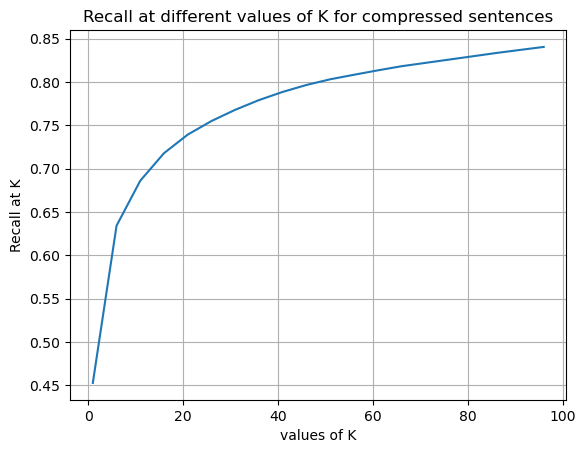

In [49]:
plt.plot(recall_index, recall_list)
plt.title("Recall at different values of K for compressed sentences")
plt.xlabel("values of K")
plt.ylabel("Recall at K")
plt.grid(True)

# answers

what should be said before anything else is how well this model performs compared to the classic word2vec we used last lab. I tuned the word2vec quite extensively, and its performance was nowhere near as good as BERT. This does not really come as a surprise, but it is still worth mentioning how vast the improvement really is. The difference was that word2vec found so many more relevant sentences per query, which indicates that it is way too general, and classifies just about anything as relevant, while BERT is able to be more specific with what is considered to be relevant. 

for a single query, we can check the recall at different values of K. Of course, this is subject to different factors, such as K, and also the threshold for what is considered similar and what is not, it's just not great, but I wanted to experiment a bit. In this case, anything above 0.72 in cosine similarity was considered to be relevant. But given we're only using a single sentence, the increase is linear until we cap at 100. 

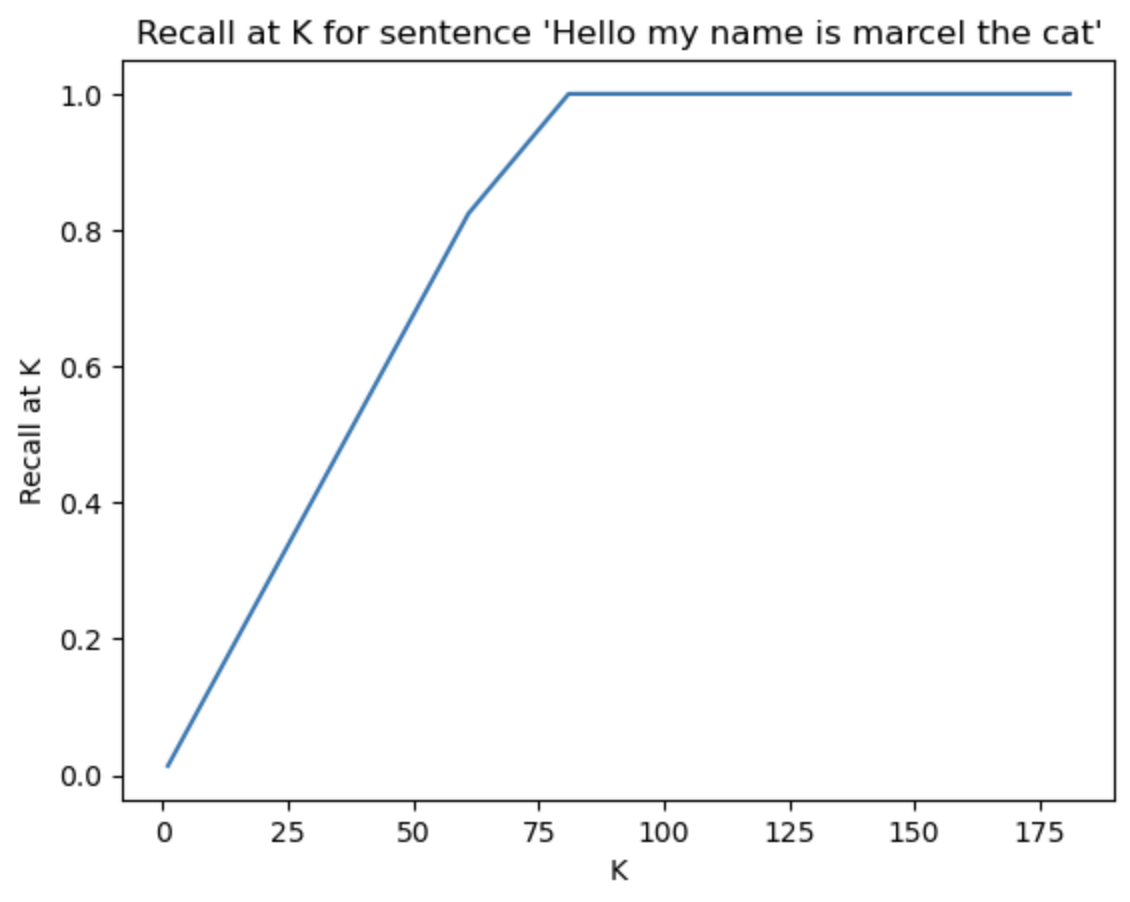

Now, for the compressed sentence we passed the function by default, we can check the same graph. Here, we see "diminishing returns" to K, if that is a valid thing to say in the first place. Higher values of K naturally lead to better recall, but more documents are also being retrieved, so there's really an almost logarithmic trend going on here. 

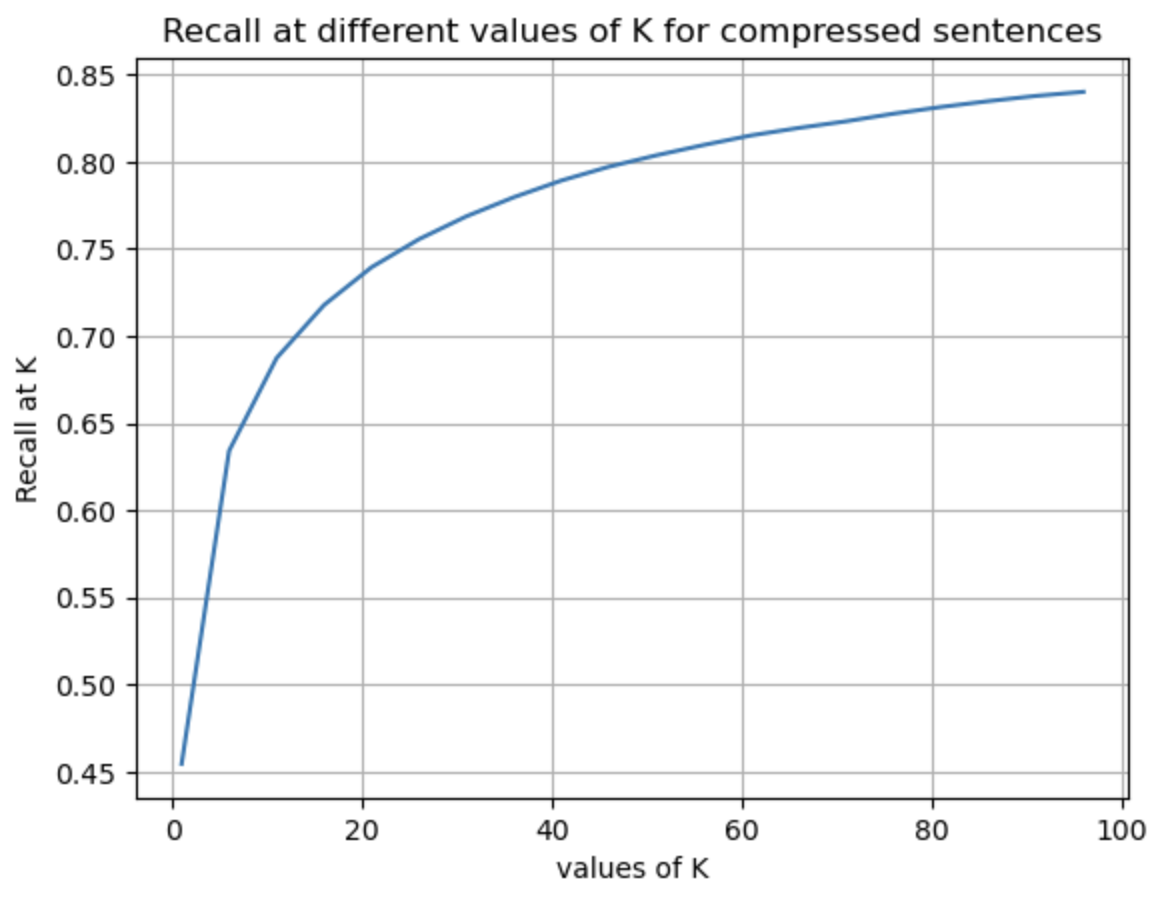

## 6. Pushing the performance: Modifying the sentence embeddings


<a name='e12'></a>
### Exercise 12 (10 points)

Experiment with the way the sentence embedding is calculated and check performance on the task.

For example, you can try using the embedding of the `CLS` token or averaging the hidden states of different layer or even averaging the representations of several layers. The choice is yours, but make sure to give a justification of your choice, based on the results and your inspection of the dataset. Make sure to inspect the representations of tokens and sentences and do not forget to evaluate the modification on the sentence retrieval task.

# my approach 

https://aclanthology.org/2023.findings-emnlp.1030.pdf 

here, i decided to average the respresentation of several layers instead of using the last layer. According to the paper i linked above, this approach can be beneficial for the performance of the model. 

this approach can potentially help us capture different levels of abstraction which come with the different layers, which maybe could help us improve our performance with this model. If my results are to be similar to those of the paper i linked above, this should prove to be a good idea. 

In [56]:
#### YOUR CODE HERE

# here, i chose to average all layers
# From what I understand, all I have to do is just modify this function that was defined
# previously in the notebook

from torch.utils.data.dataloader import DataLoader

def calculate_sentence_embeddings(input_batch, model_output, layer=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]): # average all layers
        
    mean_hidden_states_list = []

    for i in layer:
        attention_mask = input_batch['attention_mask']
        hidden_states = model_output['hidden_states'][i]

        # Apply attention mask to hidden states
        masked_hidden_states = hidden_states * attention_mask.unsqueeze(-1)

        # Sum hidden states along the sequence length
        sum_hidden_states = torch.sum(masked_hidden_states, dim=1)

        # Calculate the count of non-padding tokens for each example
        non_pad_tokens = torch.clamp(torch.sum(attention_mask, dim=1), min=1)

        # Calculate the mean of hidden states for each example
        mean_hidden_states = sum_hidden_states / non_pad_tokens.unsqueeze(-1)

        mean_hidden_states_list.append(mean_hidden_states)
        
    big_mean = torch.mean(torch.stack(mean_hidden_states_list, dim=0), dim=0)

    return big_mean

def embed_dataset(dataset, model, sentence_embedding_fn, batch_size=8):
    data_collator = transformers.DataCollatorWithPadding(tokenizer)
    data_loader = DataLoader(dataset, batch_size=batch_size, collate_fn=data_collator)
    sentence_embeddings = []
    with torch.no_grad():
        for batch in tqdm.tqdm(data_loader):
            batch.to(device)
            model_output = model(**batch, output_hidden_states=True)
            batch_sentence_embeddings = sentence_embedding_fn(batch, model_output)
            sentence_embeddings.append(batch_sentence_embeddings.detach().cpu())

    sentence_embeddings = torch.concat(sentence_embeddings, dim=0)
    return sentence_embeddings

### YOUR CODE ENDS HERE

In [57]:
# now all there is to do is to embed the datasets with the new layer as the model's output

compressed_embeddings = embed_dataset(tokenized_compressed_ds, model, calculate_sentence_embeddings)
print(compressed_embeddings.shape)

100%|██████████| 4500/4500 [04:20<00:00, 17.29it/s]

torch.Size([36000, 768])


In [58]:
sentence_embeddings = embed_dataset(tokenized_sentence_ds, model, calculate_sentence_embeddings)
print(compressed_embeddings.shape)

100%|██████████| 4500/4500 [04:29<00:00, 16.71it/s]


torch.Size([36000, 768])


In [59]:
sentences = ["the cat ate all the food",
            "the police shot at the intruders, killing them",
            "The bank is by the river",
            "natural language processing is hard",
            'mathematics is fun',
            "Rob robbed the bank by the river",
            "americans like football",
            "many people dislike celebrities like Elon Musk",
            "I like to drive my car to the supermarket",
            "Taylor Swift likes to take her plane anywhere"]

for qu in sentences:
    query_embedding = embed_query(qu, calculate_sentence_embeddings)

    query_similarity = cosine_similarity_1_to_n(query_embedding[0], sentence_embeddings)

    most_similar = int(np.argmax(query_similarity))
    print(f"OG sentence: {qu}")
    print(test_ds[most_similar]['sentence'])
    print(f'similarity: {query_similarity[idx]}')
    print("\n")

OG sentence: the cat ate all the food
The elephants consumed poisonous crops, says a committee that went into the issue.
similarity: 0.6940342783927917


OG sentence: the police shot at the intruders, killing them
A suspect has been shot and killed by Milwaukee police officers.
similarity: 0.7399473190307617


OG sentence: The bank is by the river
There's something fishy going on at the lake and the Lions Club is behind it.
similarity: 0.7003289461135864


OG sentence: natural language processing is hard
Like most technology jargons, cloud computing is best explained through users.
similarity: 0.619475781917572


OG sentence: mathematics is fun
reminders that politics can be fun.
similarity: 0.6146997213363647


OG sentence: Rob robbed the bank by the river
Police are searching for a man who attempted to rob a restaurant in the southwest part of the Valley.
similarity: 0.6948133111000061


OG sentence: americans like football
Phoenix - Baseball players love their gloves.
similarity: 0.

# answers 

## what i can say here is that using layer 8 instead of the last layer doesn't induce drastic changes to this sentence retrieval ability, but does overall reduce the performance of the model, except in a few specific cases where it actually improves it

previously, i used the last layer of the model's output to get my sentence embeddings. The results of the sentence retrieval task were not bad, but were by no means great. Let's see how they compare to the same model using the 8th hidden layer instead of the last one. I will present a couple of examples using the same sentences as before: 

- OG sentence: the cat ate all the food
- The elephants consumed poisonous crops, says a committee that went into the issue.
- similarity: 0.6940342783927917
- -> here, the model is able to make sense of the word "cat", as it finds another animal (elephant) as the subject of the retrieved sentence, and it also has "food" in a way, although not explicit. It's much better than the model using only the last layer. 

- OG sentence: the police shot at the intruders, killing them
- A suspect has been shot and killed by Milwaukee police officers.
- similarity: 0.7399473190307617
- -> Here, the retrieved sentence is very much the same as the query i passed to the model, this is impressive, it works much better than word2vec. 

- OG sentence: The bank is by the river
- There's something fishy going on at the lake and the Lions Club is behind it.
- similarity: 0.7003289461135864
- -> Here, I am quite unable to understand what the model put weight on to get to the conclusion that that sentence was the closest to the query I gave it. Neither the meaning nor the words of the query are reflected in the retrieved sentence at all, which is interesting to see. Only "river" is really taken into account here, with "lake", perhaps. 

- OG sentence: natural language processing is hard
- Like most technology jargons, cloud computing is best explained through users.
- similarity: 0.640507698059082
- -> here, the previous model found a sentence with C and C++ in it, which was really impressive given NLP and C are somewhat related, but not explicitely so. Here, I would say the fact that the model finds a sentence which is also related to computer science is very impressive, as NLP likely does not appear anywhere in the training set, from what i would suspect. 

- OG sentence: mathematics is fun
- reminders that politics can be fun.
- similarity: 0.6146997213363647
- -> here, the model finds a much better sentence than it previously did when we were only using the last layer. It finds a match to a boring subject like mathematics, and replaces it with something equally as bad, "politics". Additionally, the model finds a sentence with "fun" in it too, in my opinion the model passes this test well. Much better than word2vec too.

- OG sentence: Rob robbed the bank by the river
- Police are searching for a man who attempted to rob a restaurant in the southwest part of the Valley.
- similarity: 0.6948133111000061
- -> the retrieved sentence is not exactly similar to the query, but it captures the sense of it: the retrieved sentence is also talking about someone robbing a place, which is exactly what I gave in the query. Very good performance. 

- OG sentence: americans like football
- Phoenix - Baseball players love their gloves.
- similarity: 0.6303902268409729
- -> Here, the retrieved sentence also talks about a popular sports among Americans, and capture the sense of "like football" in a way; "love their gloves". For me, this is relevant enough to consider this a pass.

- OG sentence: many people dislike celebrities like Elon Musk
- Zooey Deschanel likes intelligent men who make her laugh.
- similarity: 0.7217358350753784
- -> Here, we find a sentence with a celebrity, and a sense of the word "dislike", except here the retrieved sentence finds "like", quite the opposite, but the sentence is still somewhat relevant. 

- OG sentence: I like to drive my car to the supermarket
- ``I would like to give away most of my clothes to charity and empty my wardrobe.
- similarity: 0.709032416343689
- -> here, the retrieved sentence really has nothing to do with my query, but given it is the only example in this exercise of a bad match, I would not pay too much attention to it, also given my original query is quite broad and non-specific. What is maybe a bit weird is the high cosine similarity the model computed for this sentence. 

- OG sentence: Taylor Swift likes to take her plane anywhere
- British supermodel Kate Moss has bought herself a black cab in order to beat the London traffic.
- similarity: 0.7008336186408997
- -> Here, the match is quite good, we find a celebrity in the sentence, and we also find a sense of the "use of a private jet", maybe? This might really be a stretch, but using a private jet beats traffic after all, and using a cab does too. Who knows, still a relevant match.

## Pushing the performance: Trying different models



<a name='e13'></a>
### Exercise 13 (10 points)

In this exercise you are asked to try other BERT-like model from huggingface. You can consider the MSMARCO model [here](https://huggingface.co/sentence-transformers/msmarco-bert-base-dot-v5). Make sure to read the model card on the huggingface website in order to understand how to use it. You don't need to install `sentence-transformers`.

As before, make sure to inspect the the representations of tokens and sentences. Evaluate the model on sentence retrieval.

# here i just used the code for the MSMARCO model as provided in the link above

In [14]:
from transformers import AutoTokenizer, AutoModel

In [15]:
# Load model from HuggingFace Hub
tokenizer = AutoTokenizer.from_pretrained("sentence-transformers/msmarco-bert-base-dot-v5")
model = AutoModel.from_pretrained("sentence-transformers/msmarco-bert-base-dot-v5")

/Users/lpaggen/miniforge3/envs/nlp/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [18]:
# Mean Pooling - Take attention mask into account for correct averaging
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output.last_hidden_state
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

# Encode text
def encode(texts):
    # Tokenize sentences
    encoded_input = tokenizer(texts, padding=True, truncation=True, return_tensors='pt')

    # Compute token embeddings
    with torch.no_grad():
        model_output = model(**encoded_input, return_dict=True)

    # Perform pooling
    embeddings = mean_pooling(model_output, encoded_input['attention_mask'])

    return embeddings

# Sentences we want sentence embeddings for
query = ["people are walking to River Bank to deposit their money"]  # Pass as a list of one string

# i just use a smaller sentence set, otherwise i am unable to get this to run on the full test or train split_ds
docs = [
    "The bank of the river was eroded after the heavy rains.",
    "She deposited her paycheck at the bank.",
    "We had a picnic on the grassy bank by the lake.",
    "He works at a bank downtown as a financial analyst.",
    "The river bank was lined with tall trees.",
    "They took a loan from the bank to buy a house.",
    "She sat on the bank of the river, watching the ducks swim.",
    "He forgot his wallet at the bank and had to go back for it.",
    "The fisherman sat on the bank, waiting for a bite.",
    "She withdrew some cash from the bank for the trip.",
    "We walked along the bank of the stream, enjoying the scenery.",
    "The bank approved her application for a mortgage.",
    "They found a hidden path on the bank of the river.",
    "He has a meeting with his banker to discuss investments.",
    "The children played on the sandy bank of the pond.",
    "She opened a savings account at the local bank.",
    "The boat was moored on the opposite bank.",
    "He transferred money from his bank account online.",
    "The floodwaters reached the top of the river bank.",
    "She checked her bank balance using the mobile app."
]



In [ ]:
#Encode query and docs
query_emb = encode(query)
doc_emb = encode(docs)

#Compute dot score between query and all document embeddings
scores = torch.mm(query_emb, doc_emb.transpose(0, 1))[0].cpu().tolist()

#Combine docs & scores
doc_score_pairs = list(zip(docs, scores))

#Sort by decreasing score
doc_score_pairs = [(doc, score) for doc, score in zip(docs, scores)] # here i just had to make a small change to the code itself, otherwise this won't run 

#Output passages & scores
print("Query:", query)
for doc, score in doc_score_pairs:
    print(score, doc)

# answer

Here, i simply used a list of 20 sentences, each containing the word "bat", in different contexts, and using different senses of the word, in an attempt to evaluate this model's performance.

The results above are very impressive; the msmarco model is able to sort the sentences it finds to be most similar to my query, very accurately. What we can observe is that I wanted to find matches for "bats live at night", and the model correctly classified all the sentences with "bat" as "animal" first, and then only did it return the other sentences using "bat" as "baseball bat". This is really impressive, as this variant of the classic BERT model beats my previous model by quite a lot. 

- Query: bats live at night
- The bat flew out of the cave at dusk. 167.17630004882812
- The bat colony lived in the old barn. 164.89450073242188
- A bat can use echolocation to navigate in the dark. 164.04103088378906
- The bat signal shone in the sky, calling the hero to action. 162.76185607910156
- The vampire bat is known for feeding on blood. 162.71722412109375
- The bat population in the area has been declining. 162.34207153320312
- The bat's wings made a rustling sound as it flew. 162.2177734375
- The fruit bat is also known as a flying fox. 162.21359252929688
- I saw a bat hanging upside down in the attic. 162.13381958007812
- She dressed up as a bat for Halloween. 161.849365234375
- She screamed when she saw a bat fly past her window. 161.5947723388672
- He practiced his swing with the bat every day. 161.2606658935547
- He swung the bat with all his might and hit a home run. 159.4757537841797
- He forgot his bat at the baseball field. 159.45848083496094
- She took a bat to the piñata at the birthday party. 159.20932006835938
- The cricket bat was signed by the legendary player. 158.86891174316406
- He held the bat tightly, ready for the pitch. 157.65333557128906
- He bought a bat and a glove from the sports store. 157.38259887695312
- The coach gave him a new bat for the season. 157.1914520263672
- He used a wooden bat instead of a metal one. 156.6034393310547

## additional examples:

For the following example, it is unsurprising, but the model is unable to make sense of this query. It goes to show that even though this model is better than before, it still was unable to make sense of the fact that "River Bank" should be the name of a financial insitution. 

- Query: people are walking to River Bank to deposit their money
- We walked along the bank of the stream, enjoying the scenery. 165.60877990722656
- She withdrew some cash from the bank for the trip. 165.3616943359375
- The river bank was lined with tall trees. 165.22189331054688
- She deposited her paycheck at the bank. 165.13861083984375
- The bank of the river was eroded after the heavy rains. 164.31724548339844
- They found a hidden path on the bank of the river. 163.5777130126953
- The fisherman sat on the bank, waiting for a bite. 163.11325073242188
- He works at a bank downtown as a financial analyst. 162.93228149414062
- The floodwaters reached the top of the river bank. 162.88397216796875
- She sat on the bank of the river, watching the ducks swim. 162.52159118652344
- They took a loan from the bank to buy a house. 161.55853271484375
- He has a meeting with his banker to discuss investments. 161.1601104736328
- He forgot his wallet at the bank and had to go back for it. 160.9654998779297
- He transferred money from his bank account online. 160.72650146484375
- She opened a savings account at the local bank. 160.46778869628906
- She checked her bank balance using the mobile app. 159.69625854492188
- The boat was moored on the opposite bank. 159.5098419189453
- The children played on the sandy bank of the pond. 158.4212646484375
- We had a picnic on the grassy bank by the lake. 157.8748779296875
- The bank approved her application for a mortgage. 157.5290985107422